# Problem statement


In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is to build a machine learning model that is able to predict churning customers based on the features provided for their usage.

Customer behaviour during churn:

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. In this case, since you are working over a four

### Objective of CaseStudy

The main goal of the case study is to build ML models to predict churn. The predictive model that you’re going to build will the following purposes:

- It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.

- It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.

- Even though overall accuracy will be your primary evaluation metric, you should also mention other metrics like precision, recall, etc. for the different models that can be used for evaluation purposes based on different business objectives. For example, in this problem statement, one business goal can be to build an ML model that identifies customers who'll definitely churn with more accuracy as compared to the ones who'll not churn. Make sure you mention which metric can be used in such scenarios.

- Recommend strategies to manage customer churn based on your observations.

In [132]:
#importing necessary libraries
import pandas as pd
import numpy as np
import re
import os

#Sklearn 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.metrics import (classification_report,precision_recall_curve,
                             balanced_accuracy_score)
#Plotting libraries better analysis
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 300)

#warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [133]:
RANDOM_STATE = 42
np.bool = np.bool_

In [134]:
data = pd.read_csv('train.csv')
unseen = pd.read_csv('test.csv').set_index('id')
sample = pd.read_csv('sample.csv')
data_dict= pd.read_csv('data_dictionary.csv')

In [135]:
unseen = pd.read_csv('test.csv').set_index('id')

# 1.Data understanding 

In [136]:
print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 170)
(30000, 2)
(36, 2)


In [137]:
#since shape of 2 dataframes are different, lets find which column is missing
missing_columns_in_unseen = set(data.columns) - set(unseen.columns)
missing_columns_in_data = set(unseen.columns) - set(data.columns)

print("Columns missing in 'unseen' DataFrame:", missing_columns_in_unseen)
print("Columns missing in 'data' DataFrame:", missing_columns_in_data)

Columns missing in 'unseen' DataFrame: {'churn_probability', 'id'}
Columns missing in 'data' DataFrame: set()


In [138]:
data.head(10)

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.00,0.00,0.00,0.00,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.00,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.00,0.00,0.00,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.00,0.00,0.00,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,

In [139]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data.info(verbose=True)
#There are columns with object datatype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

# 2. EDA & Feature Engineering

Remove columns having missing values for 50% of records

Creating function to drop columns with missing values based on percentage

In [140]:
def drop_columns_with_missing_values(df, threshold=.50):
    total_rows = len(df)
    missing_threshold = threshold * total_rows

    # Calculate the number of missing values in each column
    missing_counts = df.isnull().sum()

    # Get the column names where the number of missing values is greater than the threshold
    columns_to_drop = missing_counts[missing_counts > missing_threshold].index.tolist()

    # Drop the columns from the DataFrame
    df_dropped = df.drop(columns=columns_to_drop)

    return df_dropped,columns_to_drop

In [141]:
data,dropped_columns = drop_columns_with_missing_values(data, threshold=.50)

In [142]:
print(dropped_columns)

['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']


In [143]:
print(data.shape)
print(unseen.shape)

(69999, 142)
(30000, 170)


In [144]:
unseen  = unseen.drop(columns=dropped_columns)

In [145]:
# check for columns with constant/default values
constant_columns = [col for col in data.columns if data[col].nunique() == 1]
print("List of columns with constant/default values: ",constant_columns)

List of columns with constant/default values:  ['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']


In [146]:
#Drop single valued features
data =data.drop(constant_columns,axis=1)
#churn = churn.drop(columns=constant_columns)
unseen  = unseen.drop(columns=constant_columns)

In [147]:
#we can drop date columns date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8, as last day recharge amount columns for these months are present

data =data.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'],axis=1)
unseen  = unseen.drop(columns=['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'],axis=1)

In [148]:
print(data.shape)
print(unseen.shape)

(69999, 126)
(30000, 124)


In [149]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data.info(verbose=True)
#There are columns with object datatype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 126 columns):
 #    Column              Dtype  
---   ------              -----  
 0    id                  int64  
 1    arpu_6              float64
 2    arpu_7              float64
 3    arpu_8              float64
 4    onnet_mou_6         float64
 5    onnet_mou_7         float64
 6    onnet_mou_8         float64
 7    offnet_mou_6        float64
 8    offnet_mou_7        float64
 9    offnet_mou_8        float64
 10   roam_ic_mou_6       float64
 11   roam_ic_mou_7       float64
 12   roam_ic_mou_8       float64
 13   roam_og_mou_6       float64
 14   roam_og_mou_7       float64
 15   roam_og_mou_8       float64
 16   loc_og_t2t_mou_6    float64
 17   loc_og_t2t_mou_7    float64
 18   loc_og_t2t_mou_8    float64
 19   loc_og_t2m_mou_6    float64
 20   loc_og_t2m_mou_7    float64
 21   loc_og_t2m_mou_8    float64
 22   loc_og_t2f_mou_6    float64
 23   loc_og_t2f_mou_7    float64
 24   

In [150]:
print(data.shape)
print(unseen.shape)

(69999, 126)
(30000, 124)


### Univariate Analysis for the given data

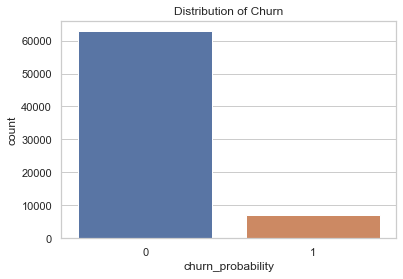

In [143]:
#distribution of the target variable (churn vs. non-churn)
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='churn_probability', data=data)
plt.title('Distribution of Churn')
plt.show()

We see very less percentage of records in dataset for customer churn usecase

In [144]:
import sweetviz as sv
#report = sv.analyze([data, "First Dataset"],target_feat='churn_probability')

# Save the report to an HTML file
#report.show_html("comparison_report.html")

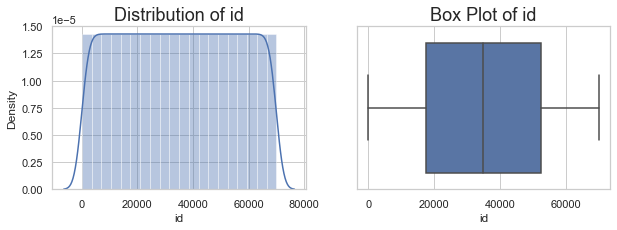

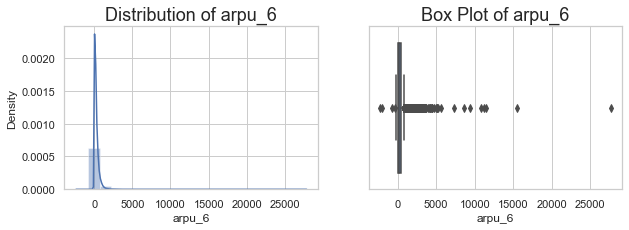

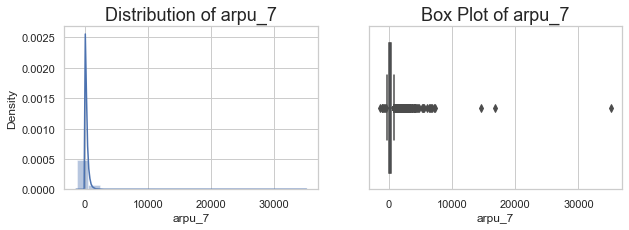

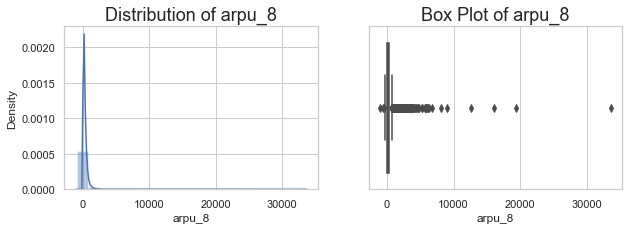

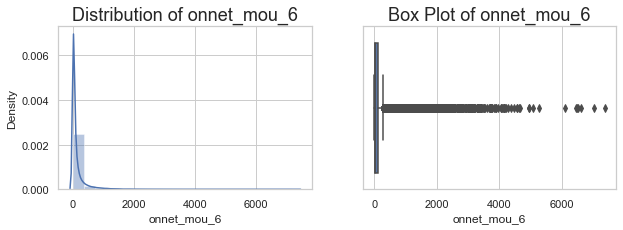

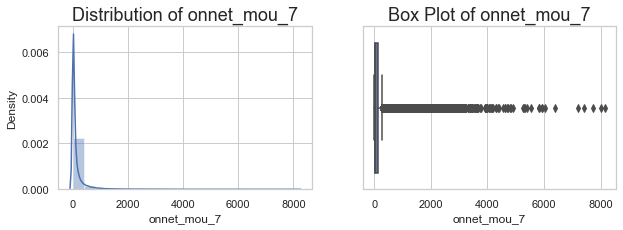

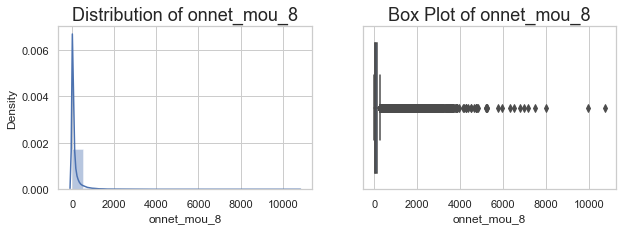

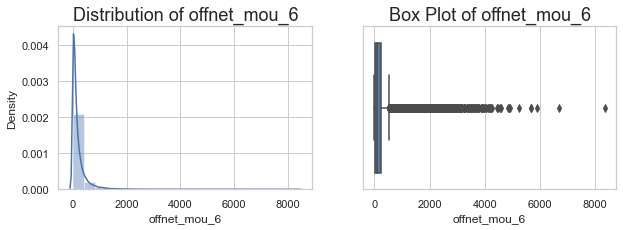

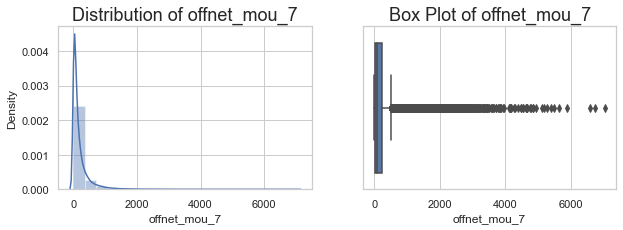

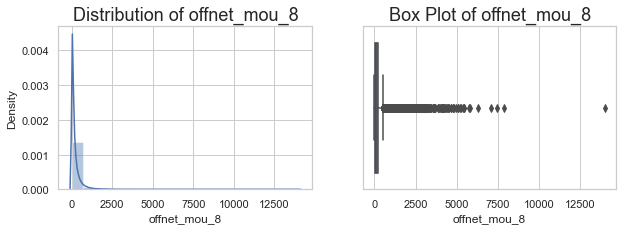

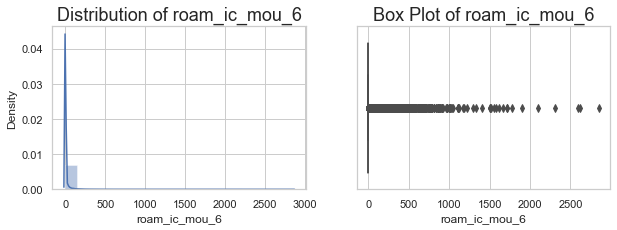

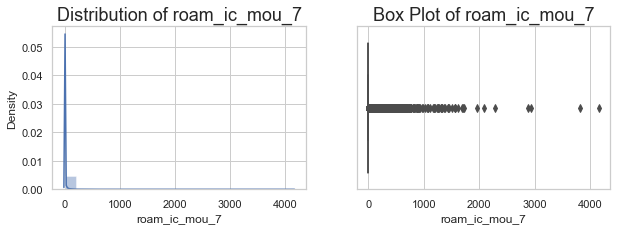

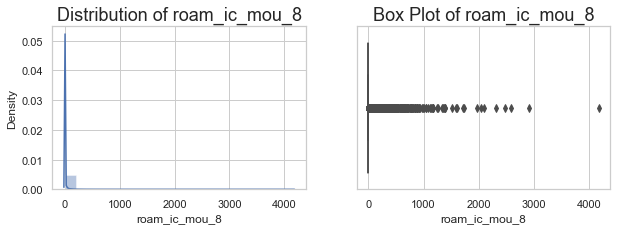

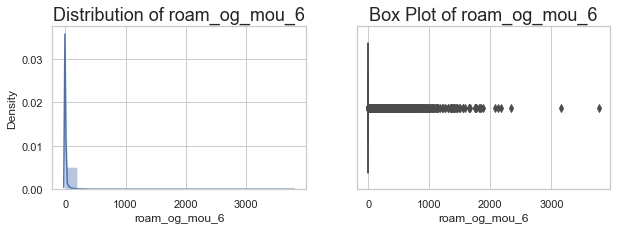

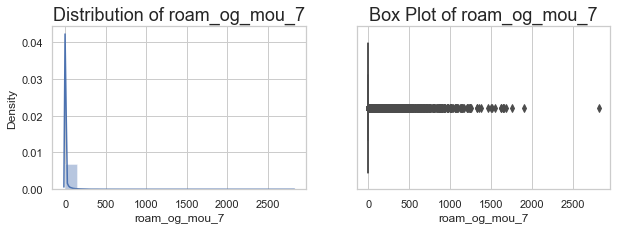

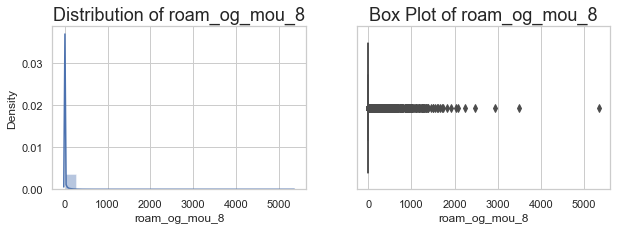

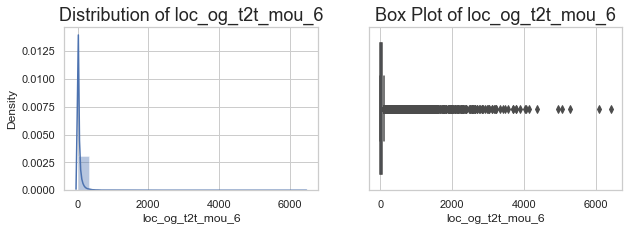

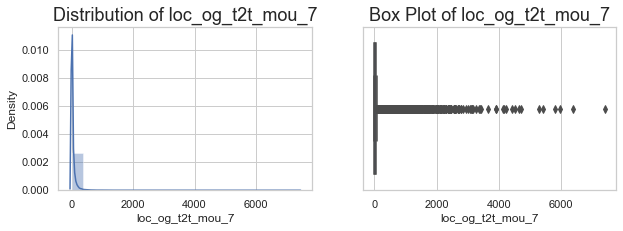

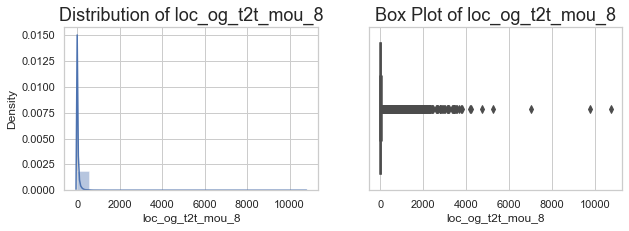

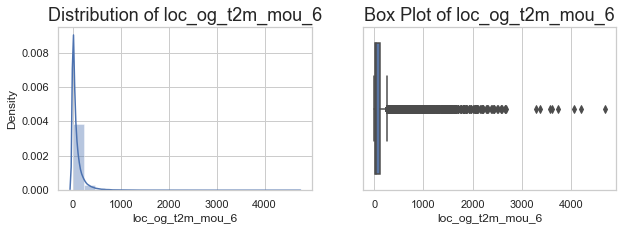

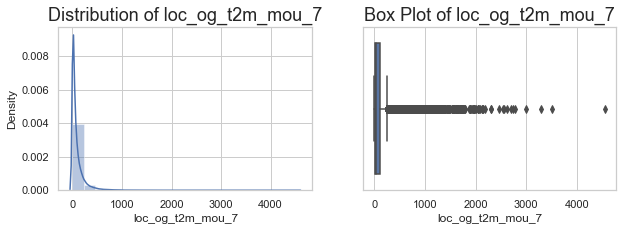

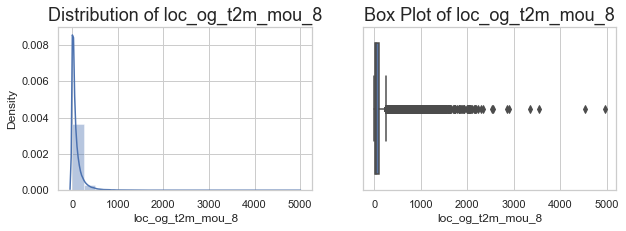

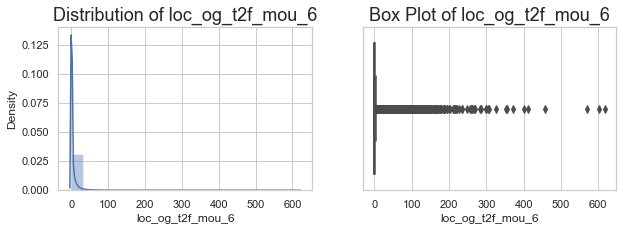

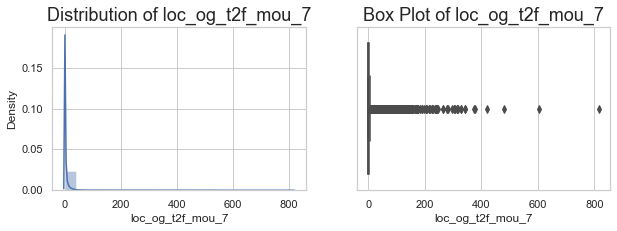

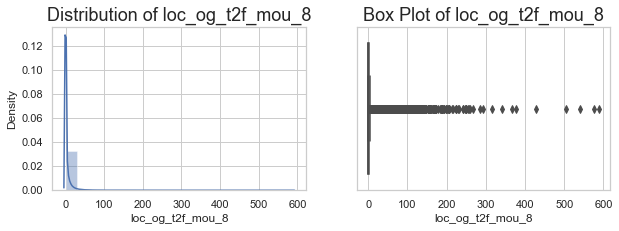

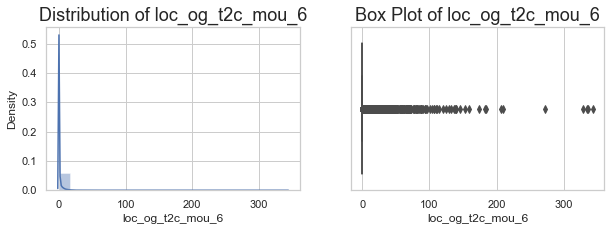

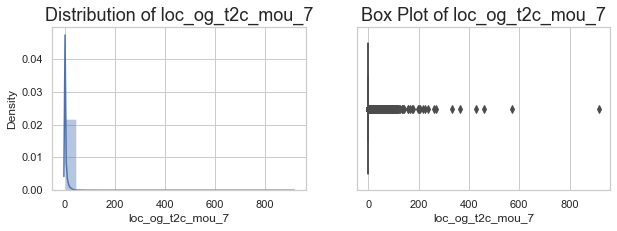

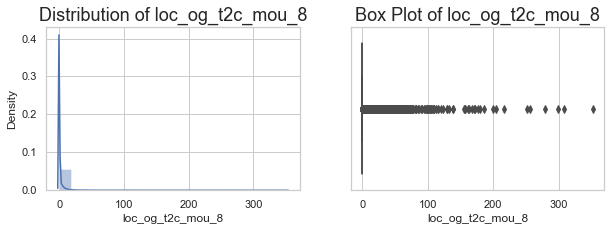

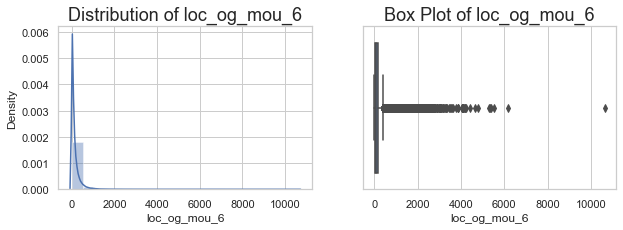

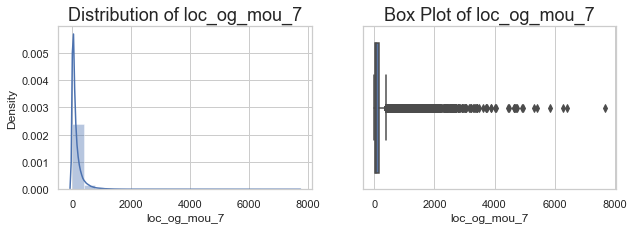

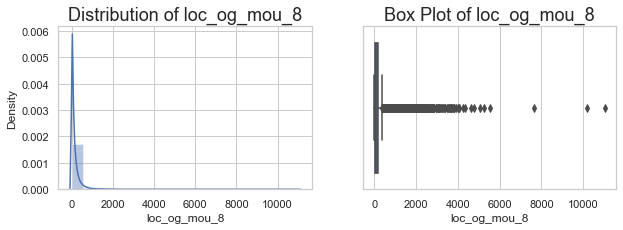

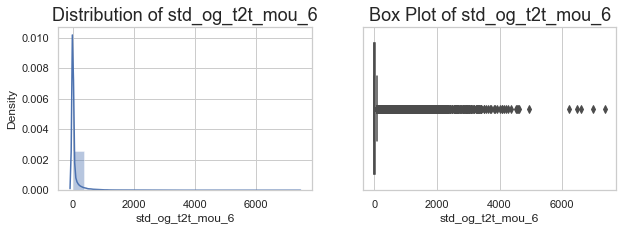

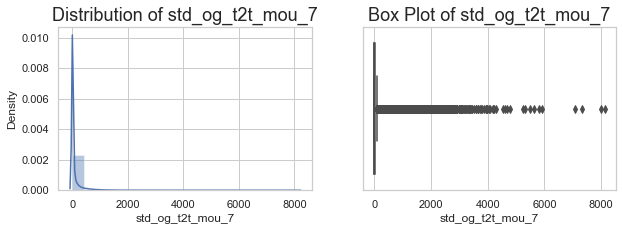

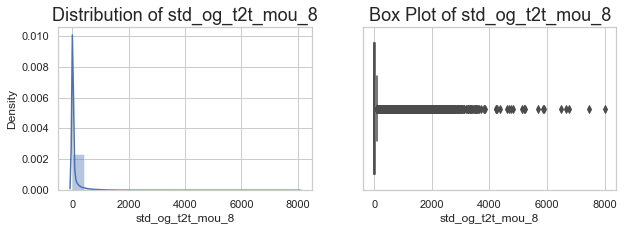

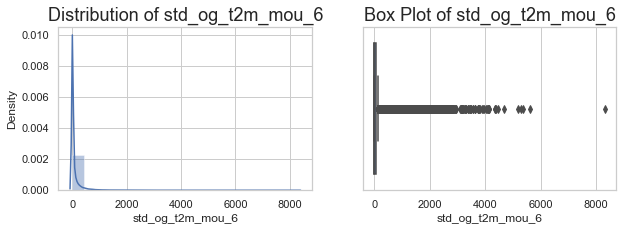

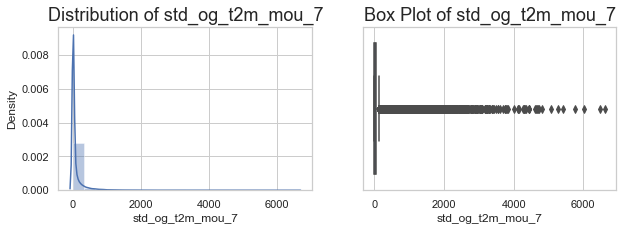

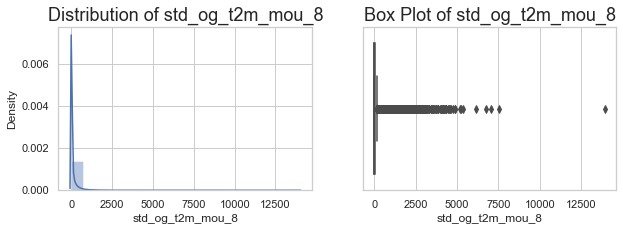

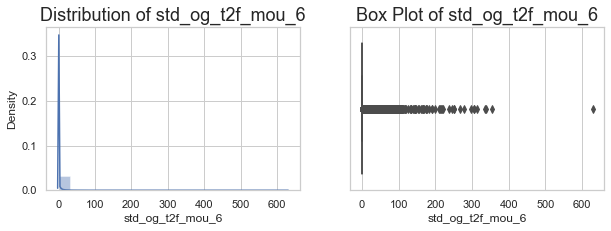

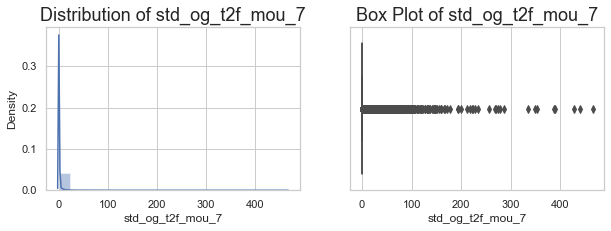

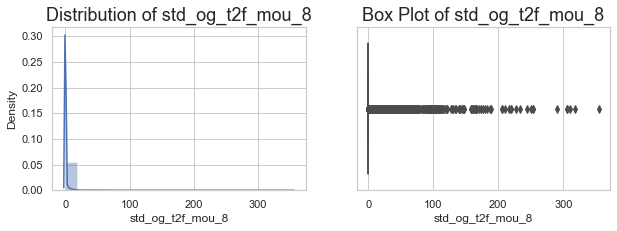

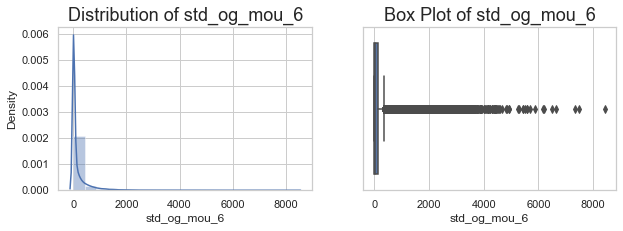

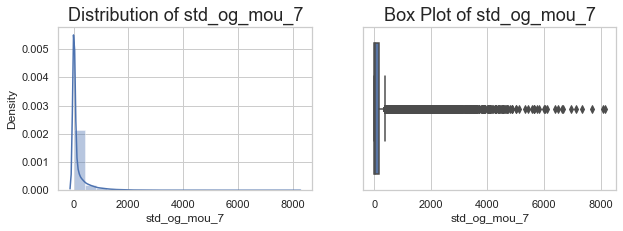

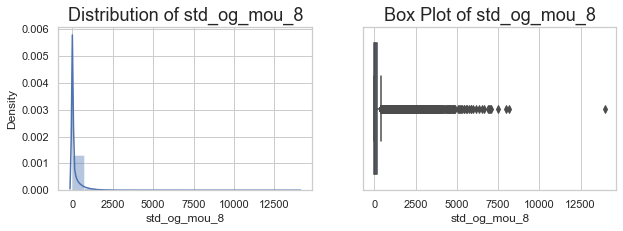

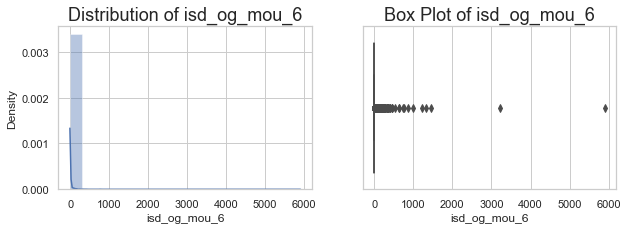

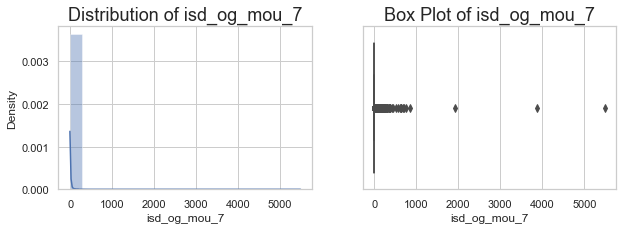

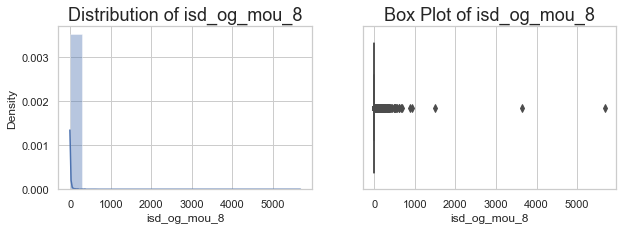

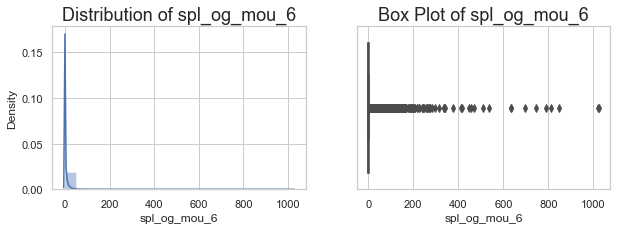

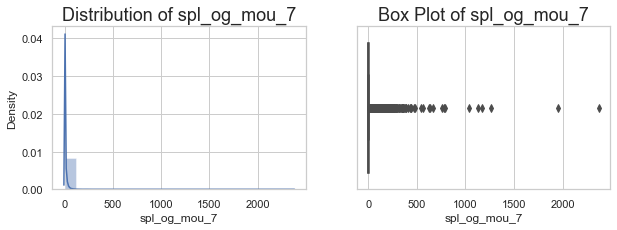

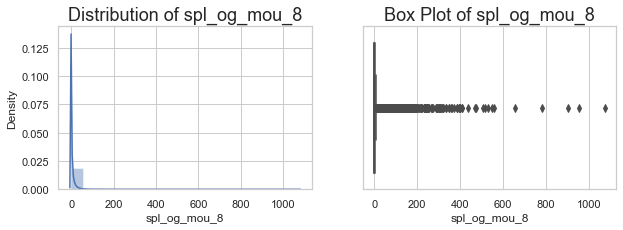

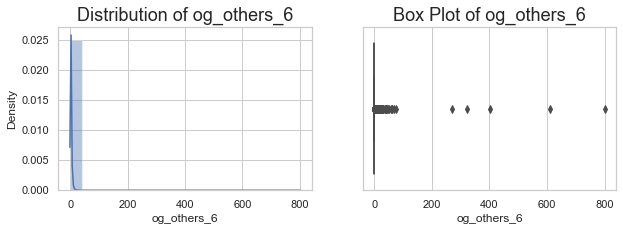

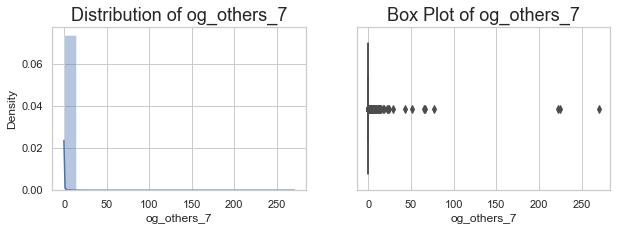

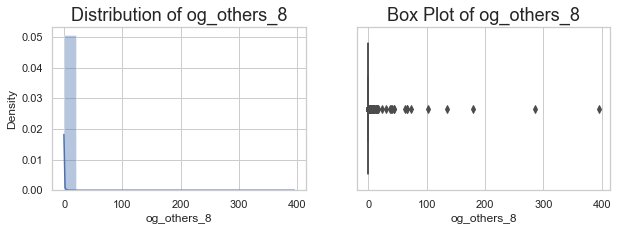

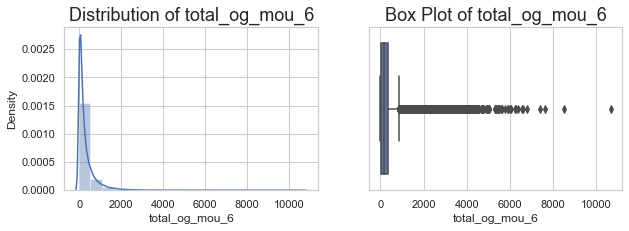

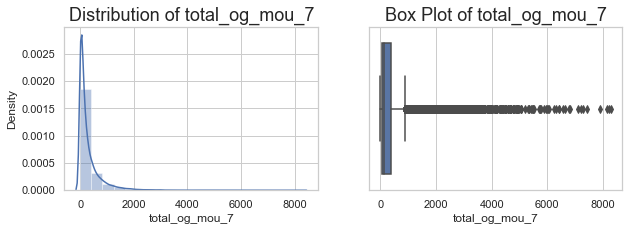

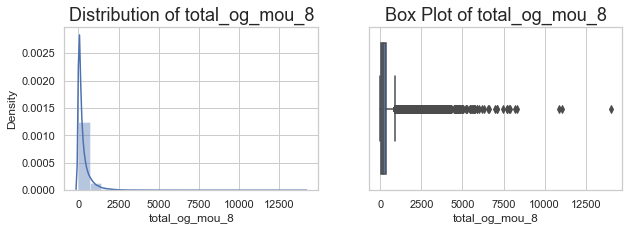

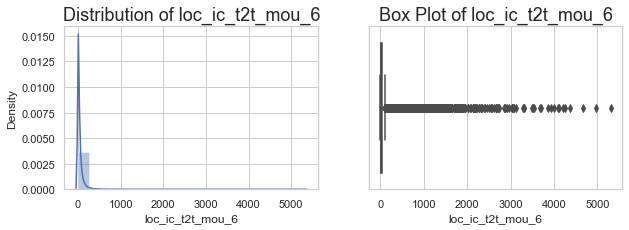

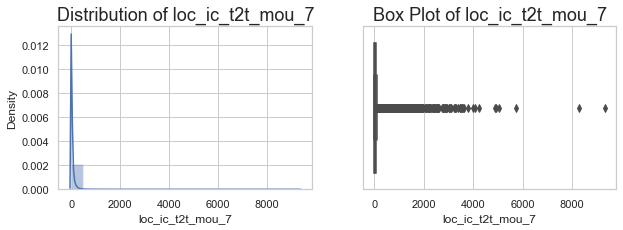

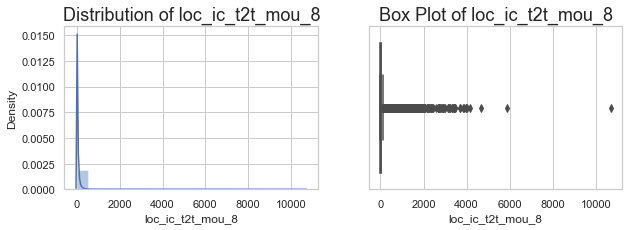

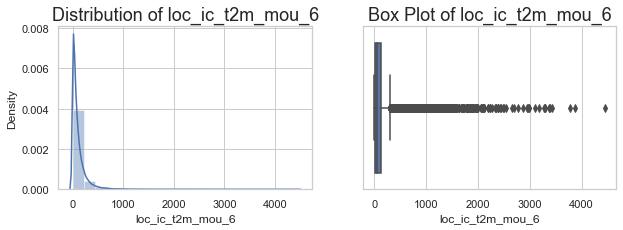

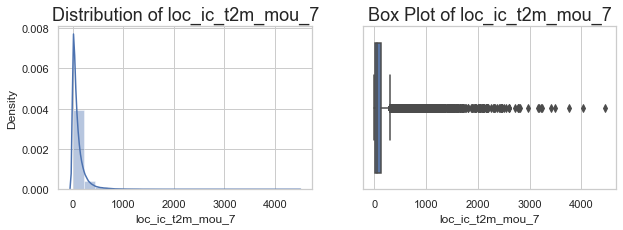

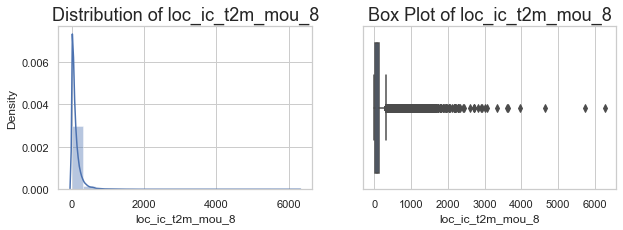

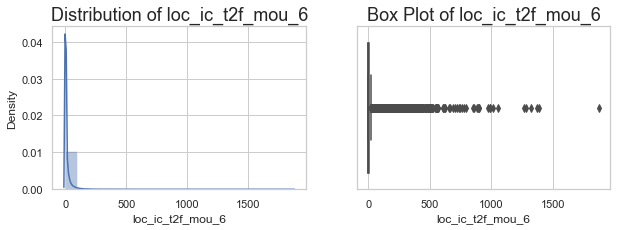

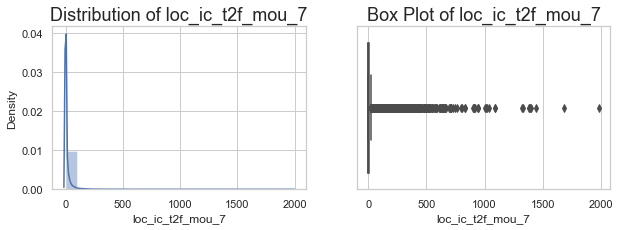

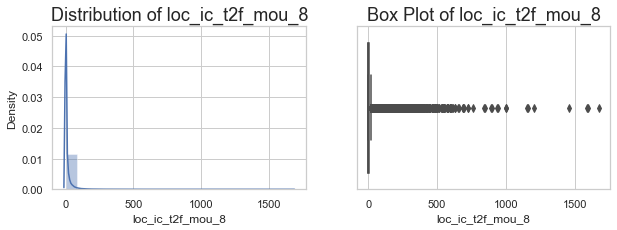

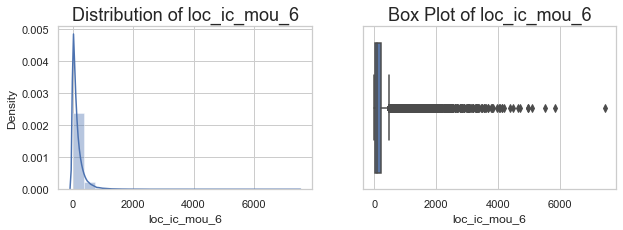

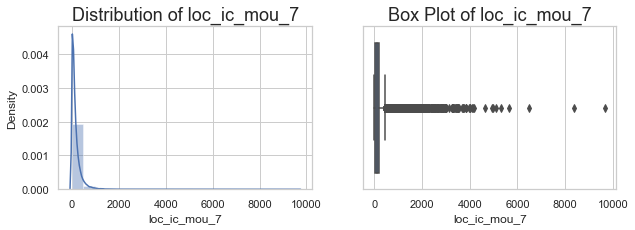

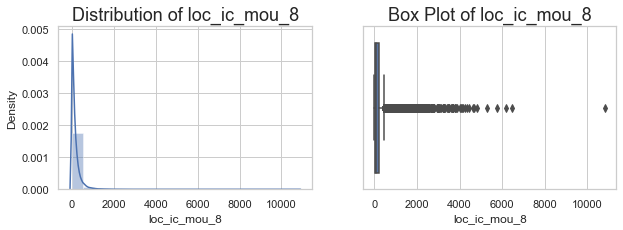

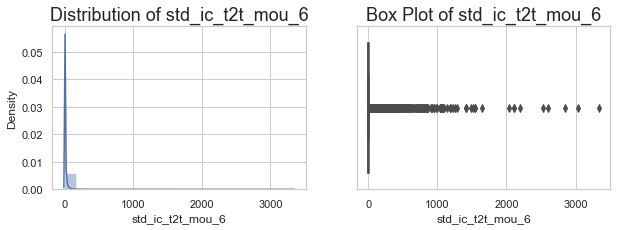

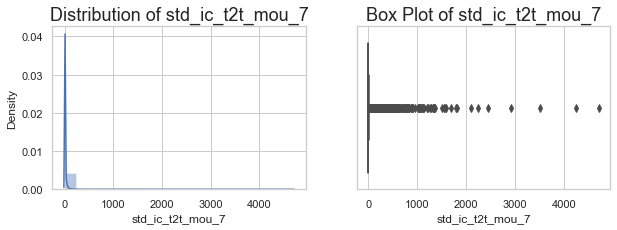

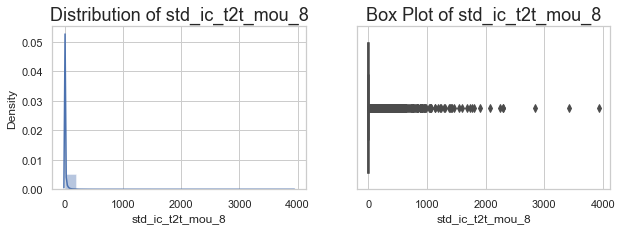

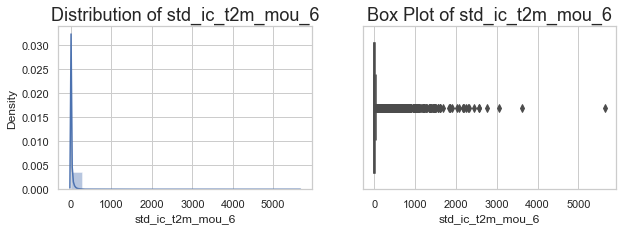

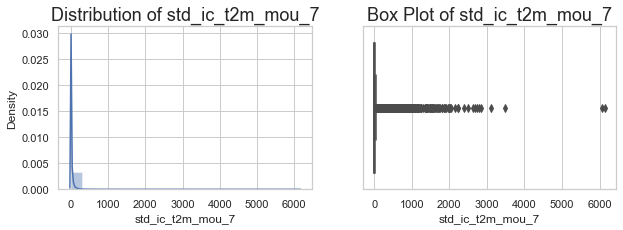

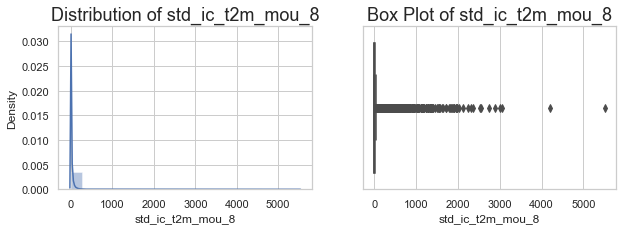

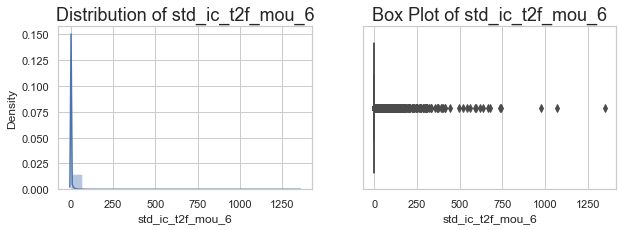

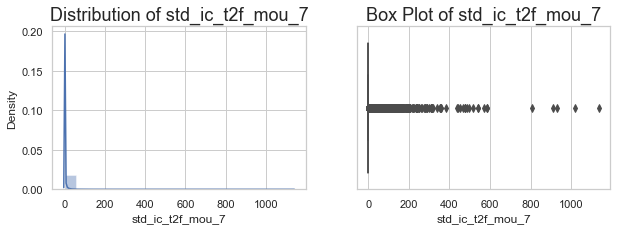

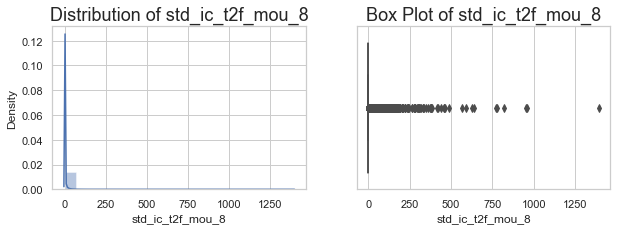

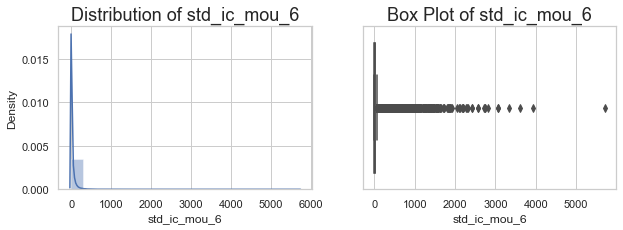

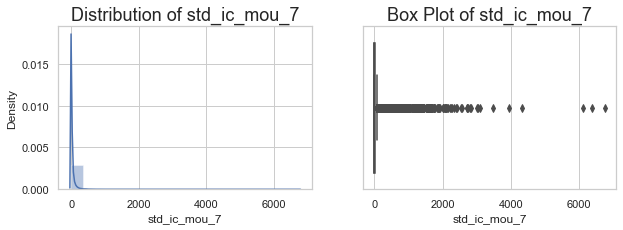

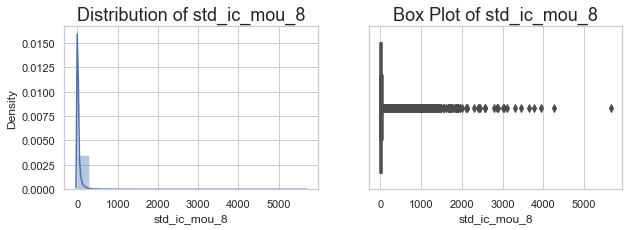

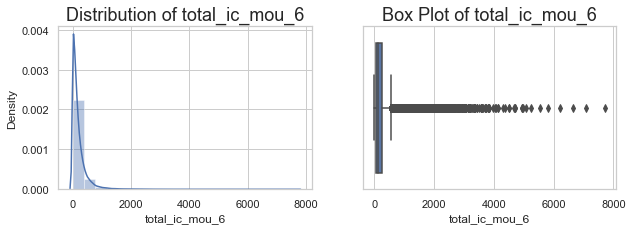

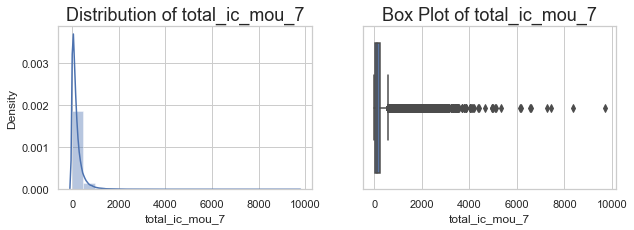

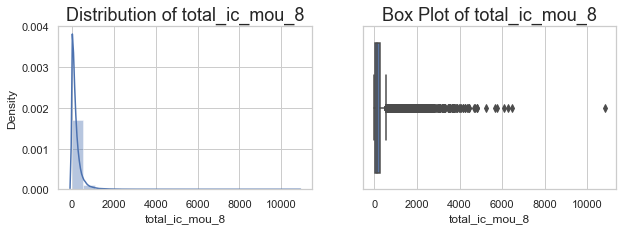

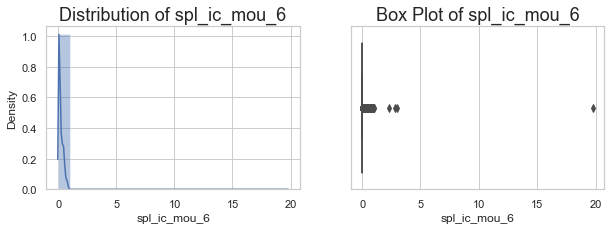

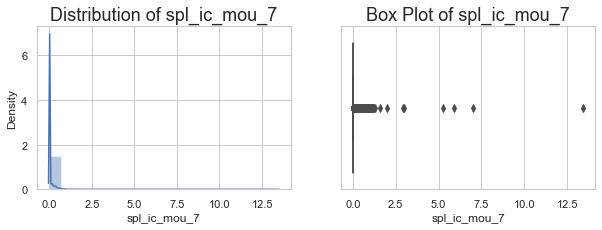

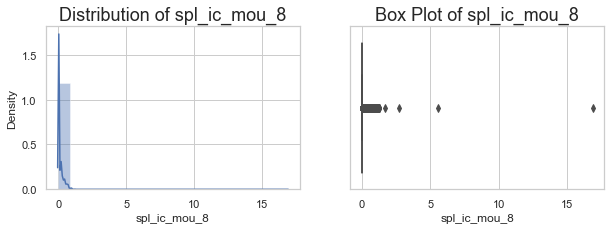

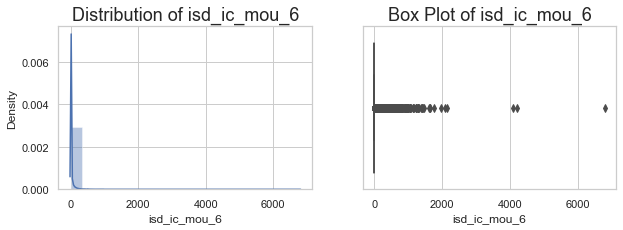

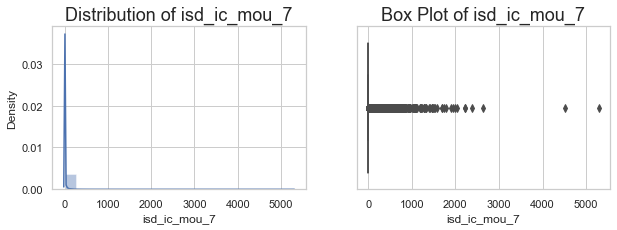

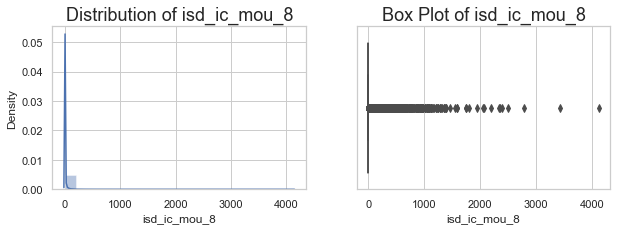

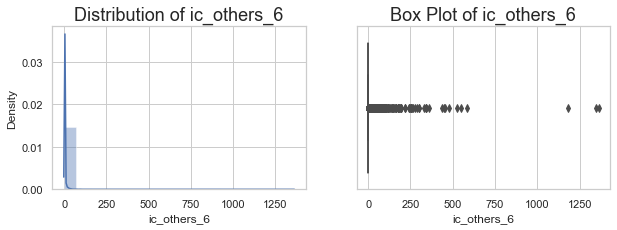

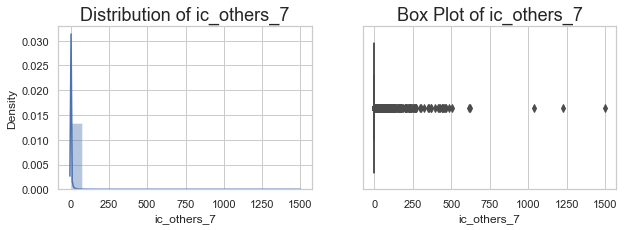

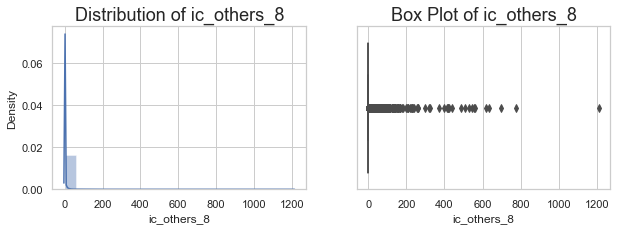

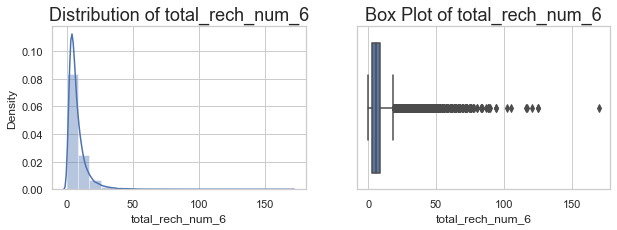

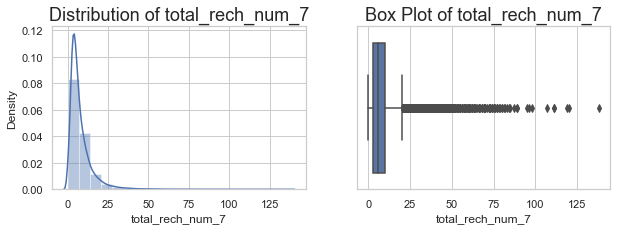

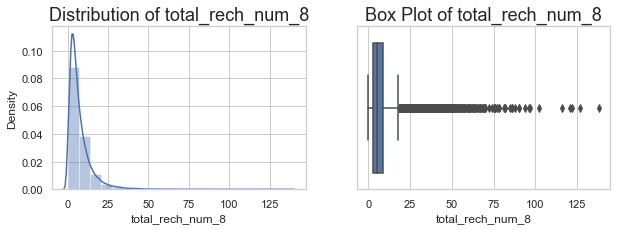

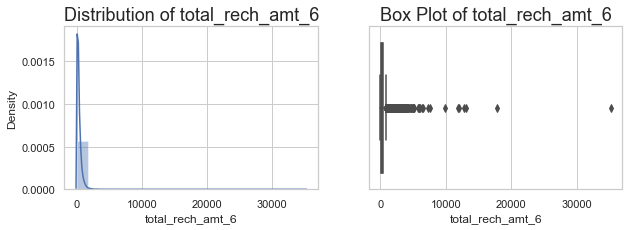

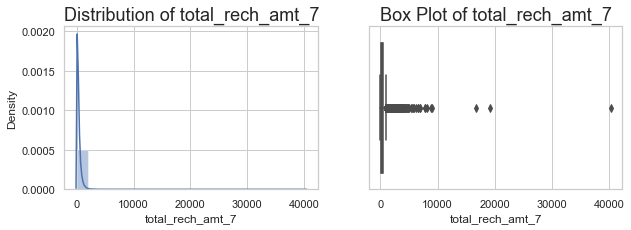

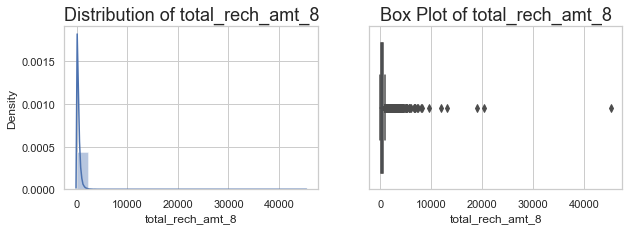

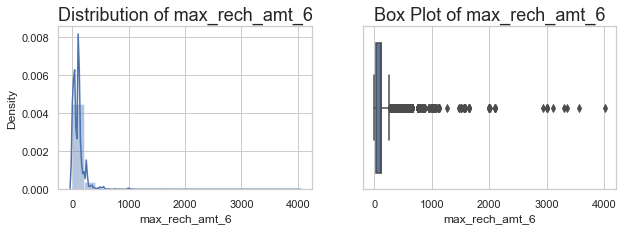

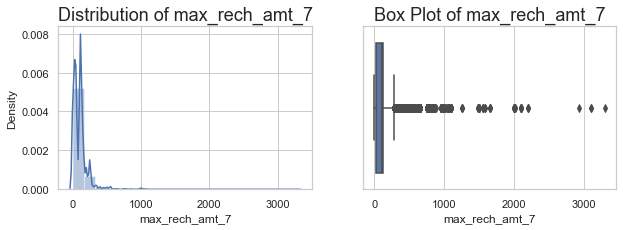

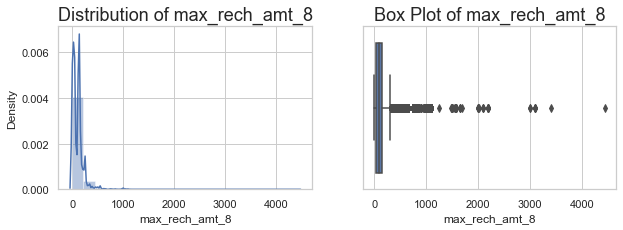

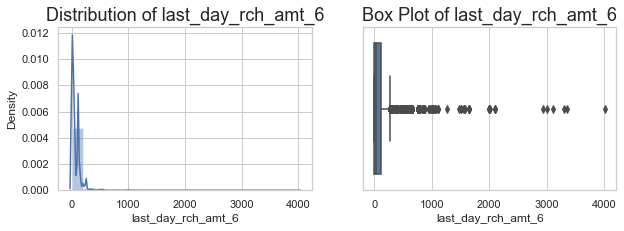

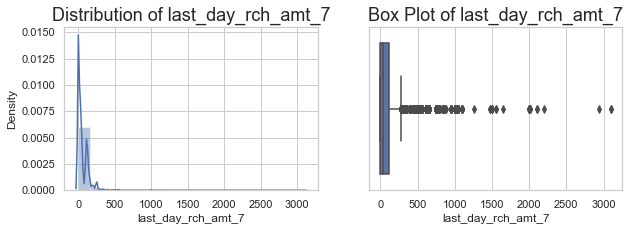

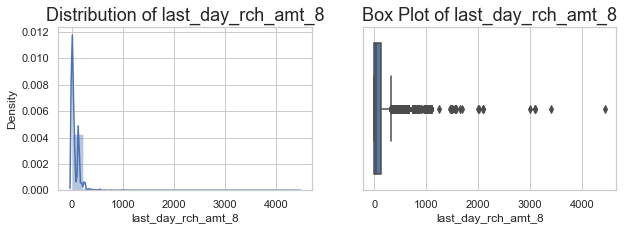

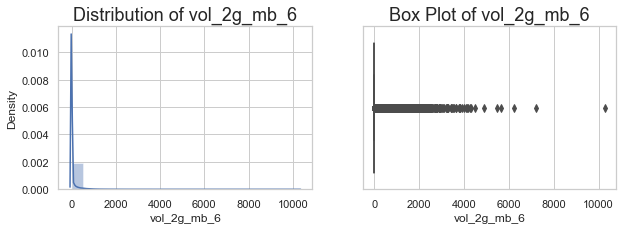

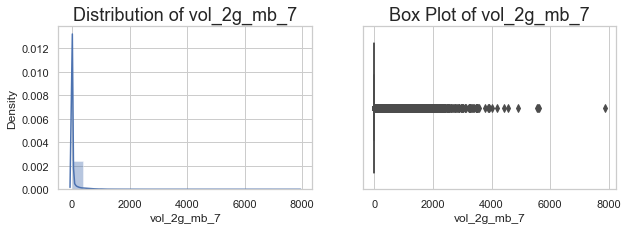

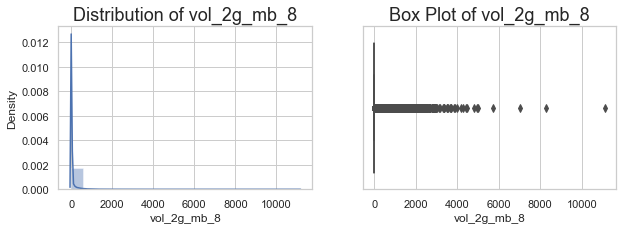

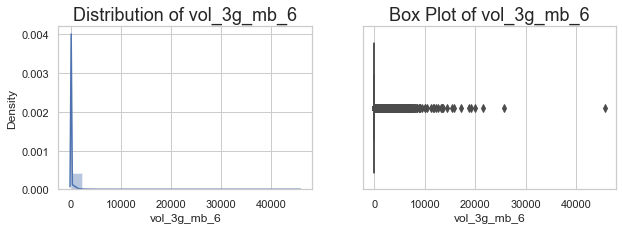

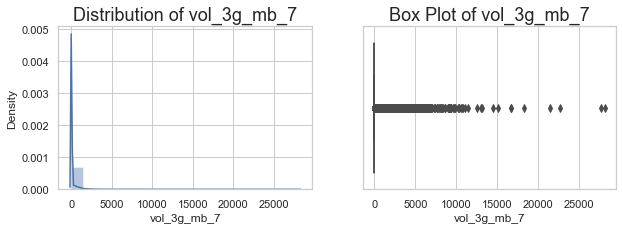

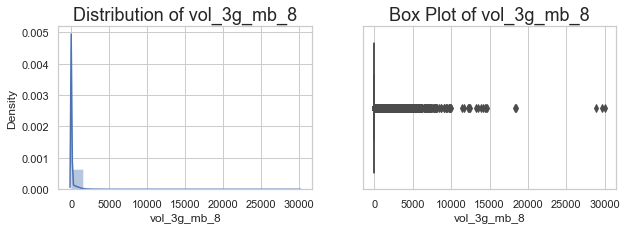

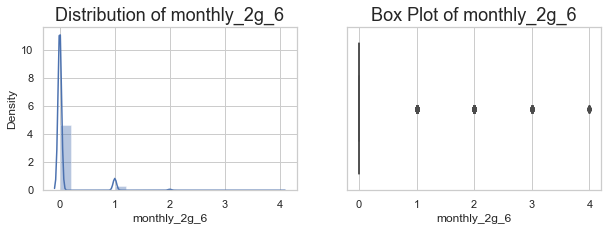

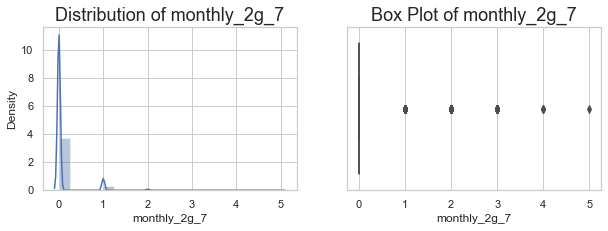

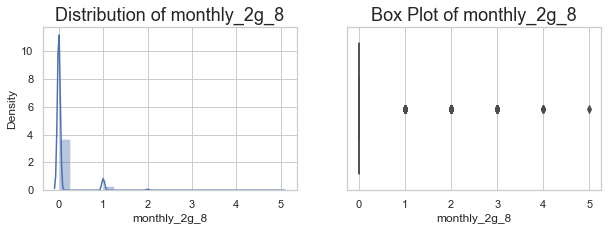

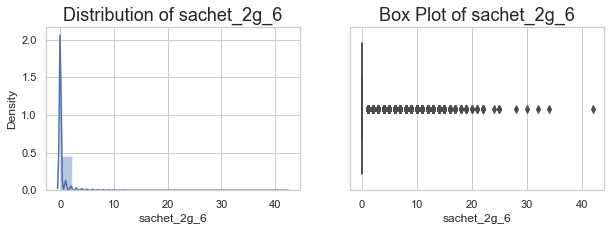

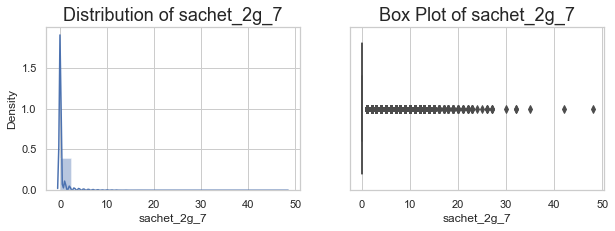

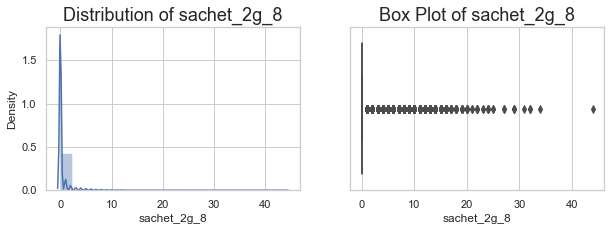

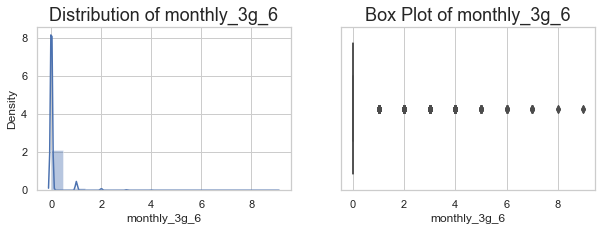

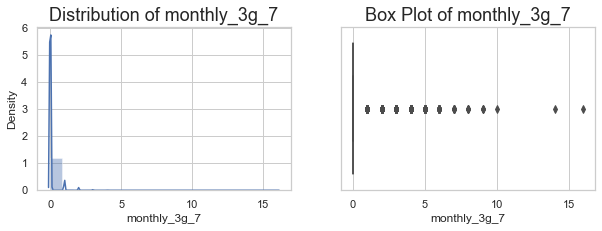

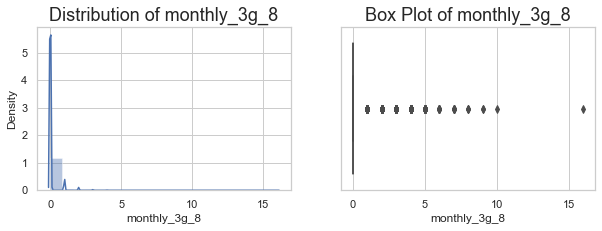

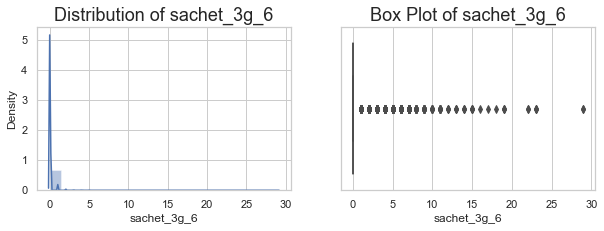

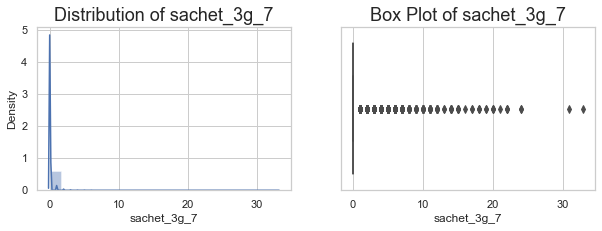

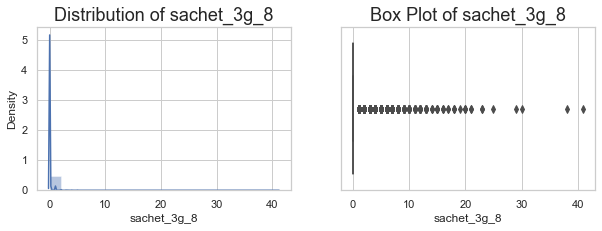

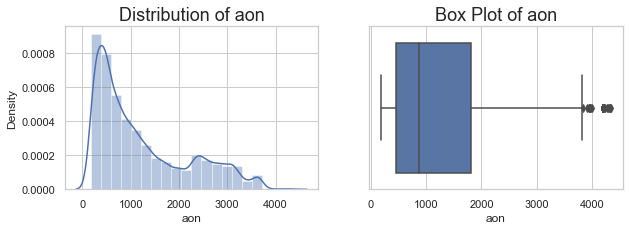

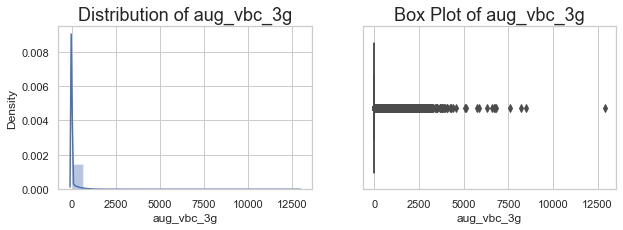

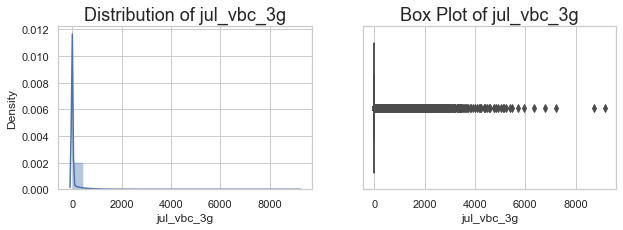

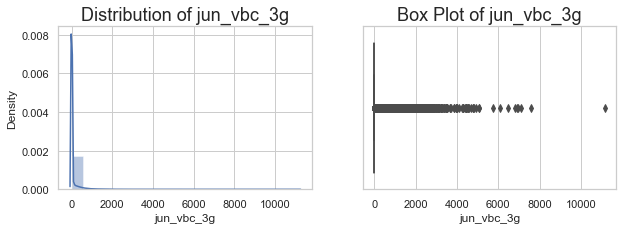

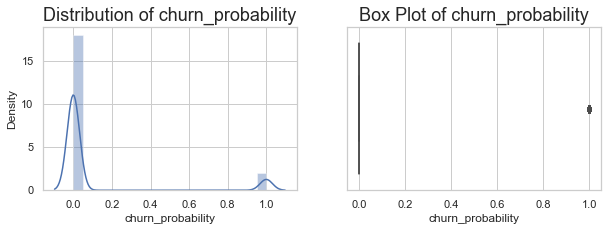

In [145]:
#numeric columns
numeric_columns = data.select_dtypes(include=["int64","float64"]).columns
for col in numeric_columns:
    # Create a new figure for each numeric column
    plt.figure(figsize=(10, 3))
       
    # Subplot 1: Distribution Plot
    plt.subplot(1, 2, 1)
    plt.title(f'Distribution of {col}', fontdict={'fontsize': 18})
    sns.distplot(data[col], bins=20)

    
    # Subplot 3: Box Plot
    plt.subplot(1, 2, 2)
    plt.title(f'Box Plot of {col}', fontdict={'fontsize': 18})
    sns.boxplot(x=col, data=data)
    
    # Display the figure for the current numeric column
    plt.show()

Outliers needs to be handled. Also we see skewed data

In [151]:
def divideFeatures(df):
    numerical_features = df.select_dtypes(include=[np.number])
    categorical_features = df.select_dtypes(include=[np.object])
    return numerical_features, categorical_features

In [152]:
# extract all skewed features
temp_numerical_features, temp_categorical_features = divideFeatures(data)
skewed_features = temp_numerical_features.apply(lambda x: x.skew()).sort_values(ascending=False)

In [22]:
print(skewed_features)

isd_og_mou_6          141.593408
isd_og_mou_8          139.653487
isd_og_mou_7          139.475406
og_others_8           130.125779
og_others_7           127.397203
og_others_6           118.034988
ic_others_6            66.971744
ic_others_7            54.758072
ic_others_8            45.753767
spl_og_mou_7           42.729168
loc_og_t2c_mou_7       42.566671
isd_ic_mou_6           39.014140
std_ic_t2f_mou_8       33.495881
std_ic_t2t_mou_7       32.231431
std_ic_t2f_mou_6       31.133297
std_ic_t2f_mou_7       28.164343
spl_ic_mou_6           27.434156
roam_ic_mou_7          27.373082
isd_ic_mou_7           27.195691
std_ic_t2t_mou_8       25.965310
std_ic_t2t_mou_6       25.908966
roam_ic_mou_8          25.776788
spl_ic_mou_8           25.569164
spl_og_mou_6           25.086386
roam_og_mou_8          23.746728
std_og_t2f_mou_7       23.472912
std_og_t2f_mou_6       23.464522
total_rech_amt_8       22.666016
loc_og_t2c_mou_6       22.473857
isd_ic_mou_8           22.244962
std_ic_t2m

In [153]:
# transform skewed features
for feat in skewed_features.index:
    # features which are more than 50% skewed are transformed
    if feat != 'churn_probability' and skewed_features.loc[feat] > 0.5:
        data[feat] = np.log1p(data[feat])

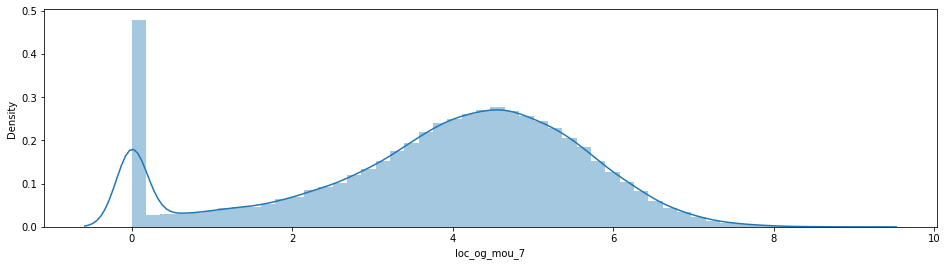

In [24]:
# plot sample treated feature
plt.figure(figsize=(16,4))
sns.distplot(data.loc_og_mou_7)
plt.show()

In [25]:
## Capping outliers to 5% at lower bound and 95% at upper bound
#for col in numeric_columns:
#    data[col][data[col] <= data[col].quantile(0.05)] = data[col].quantile(0.05)
#    data[col][data[col] >= data[col].quantile(0.95)] = data[col].quantile(0.95)

In [154]:
# two types of outliers:- statistical- domain specific
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [155]:
#Handling statistical outlier
data = data.apply(cap_outliers, axis=0)

In [29]:
data.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,3.474355,4.477439,2.143238,3.903588,4.831349,0.828552,3.503754,4.581697,1.202972,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.172482,0.000000,0.246860,1.838961,2.835564,1.202972,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.143589,2.835564,1.283708,3.857356,4.831349,0.698135,2.983153,4.401952,0.000000,0.000000,0.0,0.0,4.191017,5.327828,0.698135,0.0,0.0,0.0,2.219203,0.488580,0.000000,0.322083,0.0,0.0,4.409277,5.405736,1.532557,1.232560,1.543298,2.173615,0.604316,3.094672,2.885359,0.000000,0.000000,0.000000,1.449269,3.248823,3.246880,0.000000,2.152924,0.19062,2.135349,3.042616,2.770086,0.0,0.0,0.0,2.135349,3.352707,2.783776,2.552565,3.989725,3.727138,0.0,0.0,0.347612,0.0,0.0,0.0,0.746688,0.524729,0.000000,1.386294,1.098612,1.098612,4.356709,4.189655,2.397895,4.189655,4.189655,2.397895,4.189655,4.189655,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,7.580189,0.0,0.0,0.0,0
1,1,0.000000,4.818562,3.783121,0.000000,0.000000,0.000000,0.000000,3.295466,3.462292,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.508550,2.586422,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,3.457263,3.486151,0.000000,0.0,0.0,0.000000,3.457263,3.486151,0.985817,3.000222,2.444952,0.879627,2.979603,2.492379,0.300105,0.978326,1.481605,1.490654,3.699819,3.259250,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.490654,3.699819,3.259634,0.0,0.0,0.009950,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.386294,1.609438,1.791759,0.000000,4.983607,3.931826,0.000000,4.983607,3.931826,0.000000,0.000000,0.000000,0.000000,5.869043,0.00000,0.0,1.601406,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.646573,0.0,0.0,0.000000,0.0,6.566672,0.0,0.0,0.0,0
2,2,4.124000,4.646082,0.000000,0.425268,2.829087,0.000000,4.007151,4.419443,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.425268,2.637628,0.000000,3.223266,0.000000,0.000000,0.00000,0.000000,0.000000,1.144223,0.000000,0.000000,3.244154,2.637628,0.000000,0.

In [165]:
#Lets analyze the data dictionary versus the churn dataset.
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [157]:
#Derived columns
ids = ['id']
total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)] #total amounts spent by customer across various service
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)] #total outgoing minutes used by customers across various service
offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)] #the minutes spent on calls outside the telecom network (off-net).
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)] # average revenue generated from 3G services
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]  #average revenue generated from 2G services
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)] #volume of data usage for 3G services.
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)] #volume of data usage for 2G services.
age_on_network = [i for i in list(data.columns) if re.search('aon',i)] #duration (age) of the customer's association with the telecom network

#Storing them in a single flat list
variables = [*ids,
             *total_amounts, 
             *total_outgoing_minutes, 
             *offnetwork_minutes, 
             *average_revenue_3g, 
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network, 
             'churn_probability']

data = data[variables].set_index('id')

In [158]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data.info(verbose=True)
#There are columns with object datatype

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_rech_amt_6   69999 non-null  float64
 1   total_rech_amt_7   69999 non-null  float64
 2   total_rech_amt_8   69999 non-null  float64
 3   total_og_mou_6     69999 non-null  float64
 4   total_og_mou_7     69999 non-null  float64
 5   total_og_mou_8     69999 non-null  float64
 6   offnet_mou_6       67231 non-null  float64
 7   offnet_mou_7       67312 non-null  float64
 8   offnet_mou_8       66296 non-null  float64
 9   vol_3g_mb_6        69999 non-null  float64
 10  vol_3g_mb_7        69999 non-null  float64
 11  vol_3g_mb_8        69999 non-null  float64
 12  vol_2g_mb_6        69999 non-null  float64
 13  vol_2g_mb_7        69999 non-null  float64
 14  vol_2g_mb_8        69999 non-null  float64
 15  aon                69999 non-null  float64
 16  churn_probability  69999 no

In [159]:
data.head() 

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
id,,,,,,,,,,,,,,,,,
0,4.356709,4.189655,2.397895,4.409277,5.405736,1.532557,3.503754,4.581697,1.202972,0.0,0.000000,0.0,0.000000,0.000000,0.00000,7.580189,0
1,0.000000,4.983607,3.931826,0.000000,3.457263,3.486151,0.000000,3.295466,3.462292,0.0,1.601406,0.0,0.000000,5.869043,0.00000,6.566672,0
2,4.262680,4.795791,0.000000,4.051611,4.608764,0.000000,4.007151,4.419443,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,6.783325,0
3,5.081404,5.484797,4.875197,4.344195,4.574505,4.004420,4.245061,4.375505,3.936325,0.0,0.000000,0.0,0.000000,0.000000,0.00000,6.890609,0
4,5.673323,4.919981,4.812184,4.162937,3.782825,2.818995,4.060271,3.666378,2.363680,0.0,0.000000,0.0,5.970752,5.736217,5.36817,6.473891,0


### Bivariate analysis on numeric columns

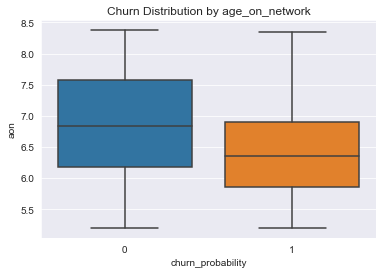

In [160]:
sns.boxplot(x = 'churn_probability', y = 'aon' ,data=data)
plt.title("Churn Distribution by age_on_network")
plt.show()

 As the duration, or age, of the customer's association with the telecom network decreases, there is an observed increase in churn.

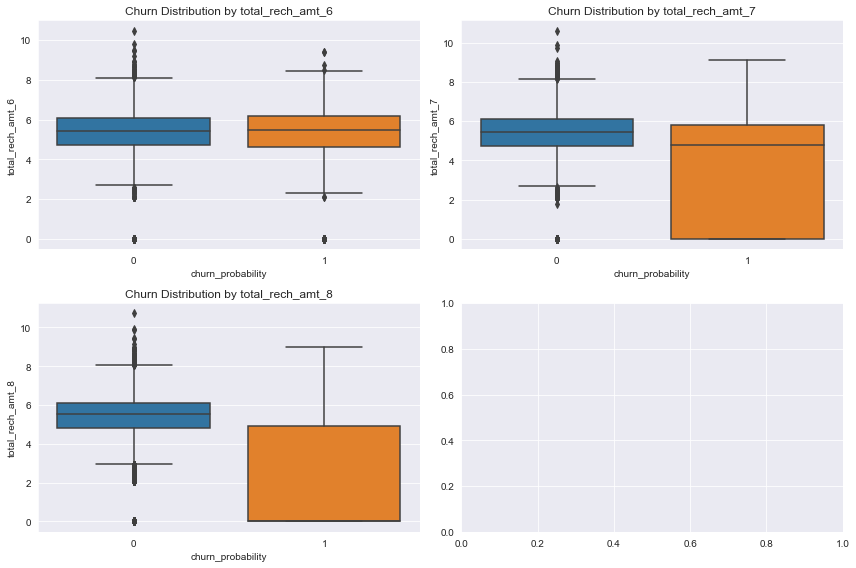

In [161]:

columns_to_plot = ['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8']

# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Flatten the subplot grid for easier indexing
axes = axes.flatten()

# Plot boxplots for each selected column
for i, column in enumerate(columns_to_plot):
    sns.boxplot(x='churn_probability', y=column, data=data, ax=axes[i])
    axes[i].set_title(f"Churn Distribution by {column}")

# Adjust layout
plt.tight_layout()
plt.show()

Customers with lower 'total recharge amount' tend to exhibit higher churn probability, particularly during the months of July (7th) and August (8th)

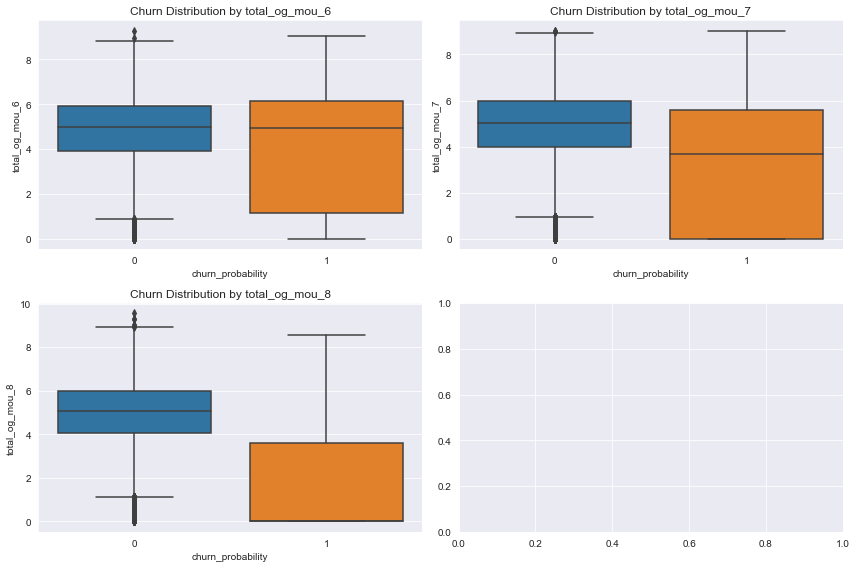

In [162]:

columns_to_plot = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']

# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Flatten the subplot grid for easier indexing
axes = axes.flatten()

# Plot boxplots for each selected column
for i, column in enumerate(columns_to_plot):
    sns.boxplot(x='churn_probability', y=column, data=data, ax=axes[i])
    axes[i].set_title(f"Churn Distribution by {column}")

# Adjust layout
plt.tight_layout()
plt.show()

Target the customers, whose outgoing others charge in July and incoming others on August are less.

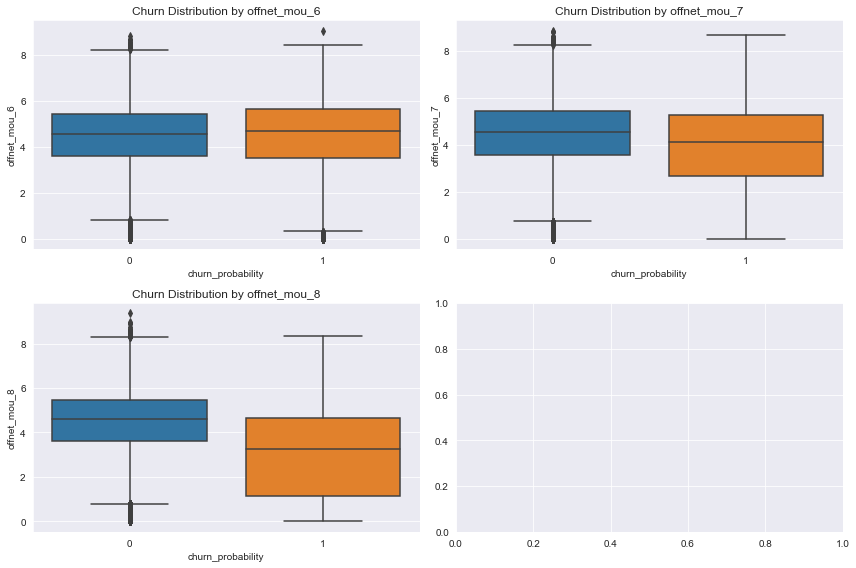

In [163]:

columns_to_plot = ['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']

# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Flatten the subplot grid for easier indexing
axes = axes.flatten()

# Plot boxplots for each selected column
for i, column in enumerate(columns_to_plot):
    sns.boxplot(x='churn_probability', y=column, data=data, ax=axes[i])
    axes[i].set_title(f"Churn Distribution by {column}")

# Adjust layout
plt.tight_layout()
plt.show()

Customers having decreasing incoming minutes of usage for operators T to fixed lines of T for August are more likely to churn.

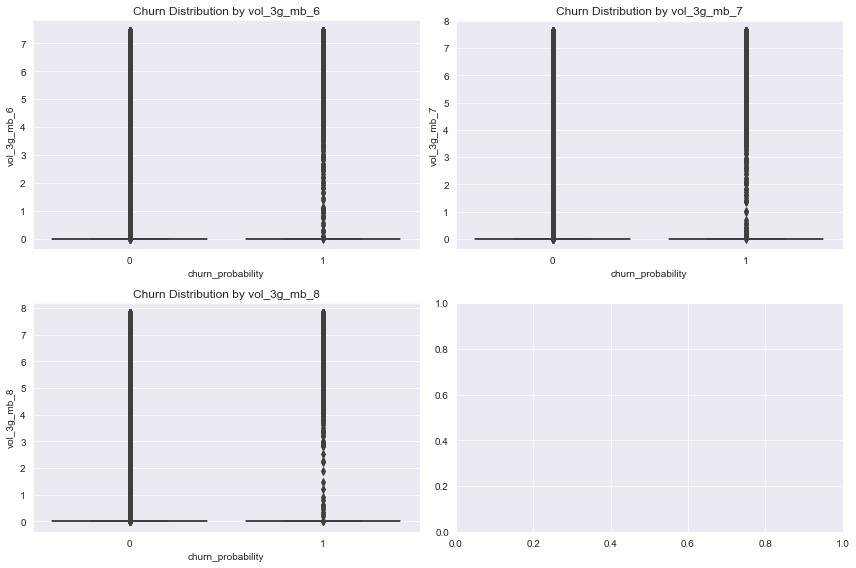

In [164]:
columns_to_plot = ['vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8']

# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Flatten the subplot grid for easier indexing
axes = axes.flatten()

# Plot boxplots for each selected column
for i, column in enumerate(columns_to_plot):
    sns.boxplot(x='churn_probability', y=column, data=data, ax=axes[i])
    axes[i].set_title(f"Churn Distribution by {column}")

# Adjust layout
plt.tight_layout()
plt.show()

Cutomers, whose monthly 3G recharge in August is more, are likely to be churned.

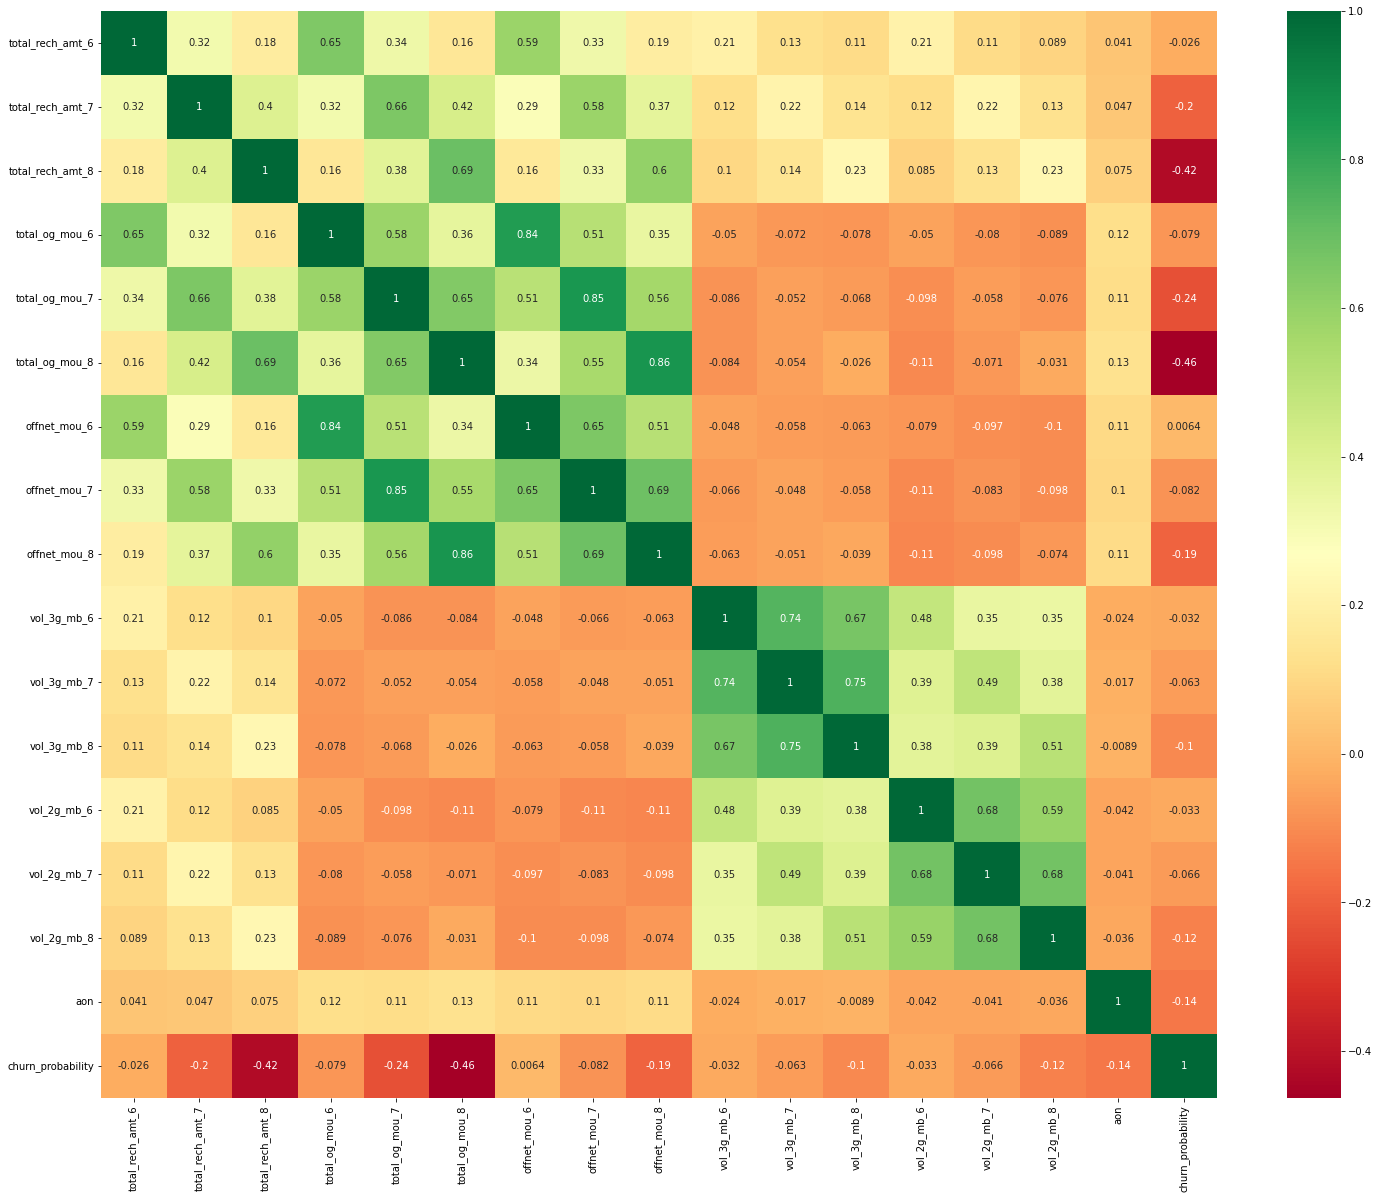

In [35]:
# Plot heatmap to detect correlations among numerical variables
correlation_matrix=data.corr()
plt.figure(figsize=(25,20))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn');

There exists a significant negative correlation between the variables 'total_rech_amt_8' and 'total_og_mou_8.' This implies that, as the total recharge amount ('total_rech_amt_8') for a customer in the eighth month increases, the corresponding total outgoing minutes of usage ('total_og_mou_8') decrease, and vice versa. This negative correlation suggests an intriguing relationship between the customer's recharge behavior and their engagement in outgoing calls during the specified month

In [36]:

# Handling NAN for categorical columns -Filling with the mode (most frequent value)
object_datatype_columns = data.select_dtypes(include=["object"]).columns
for column in object_datatype_columns:
    mode_value = data[column].mode().iloc[0]  # Calculate the mode
    data[column].fillna(mode_value, inplace=True)
    
# Handling NAN for numeric columns -Filling with zero
numeric_columns = data.select_dtypes(include=["int64","float64"]).columns
for column in numeric_columns:
    data[column].fillna(0, inplace=True)

In [37]:


# Handling NAN for numeric columns -Filling with zero
numeric_columns_unseen = unseen.select_dtypes(include=["int64","float64"]).columns
for column in numeric_columns_unseen:
    unseen[column].fillna(0, inplace=True)

<Axes: >

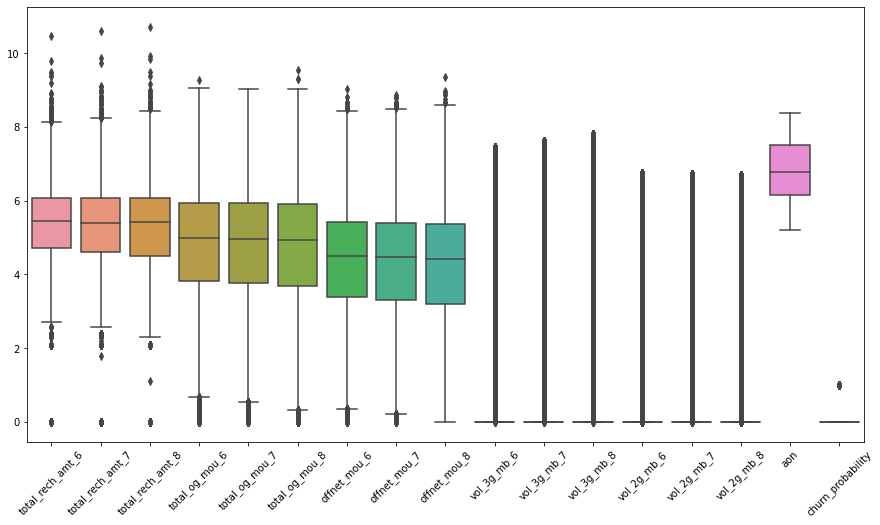

In [38]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(data))

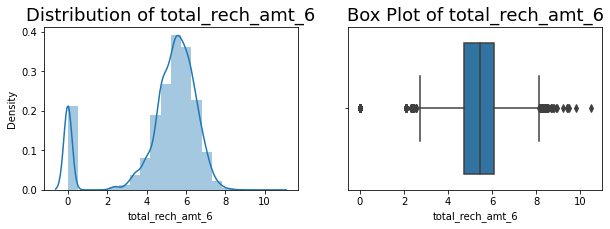

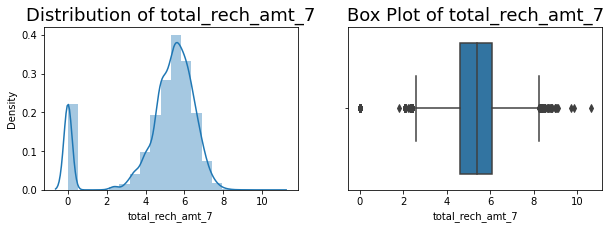

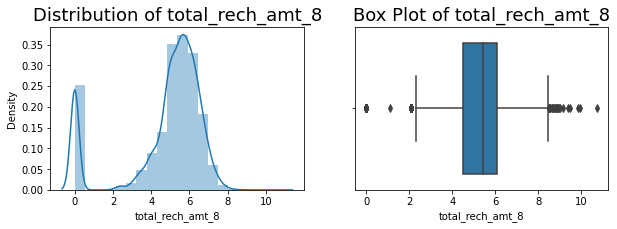

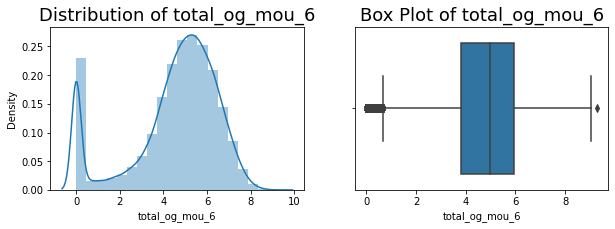

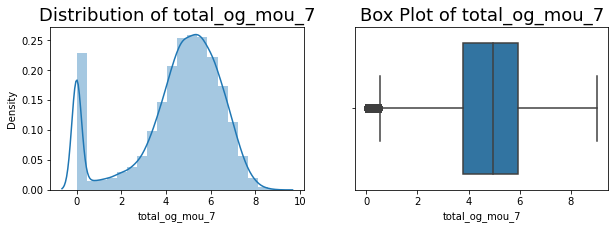

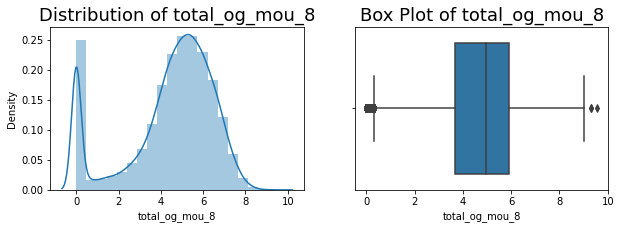

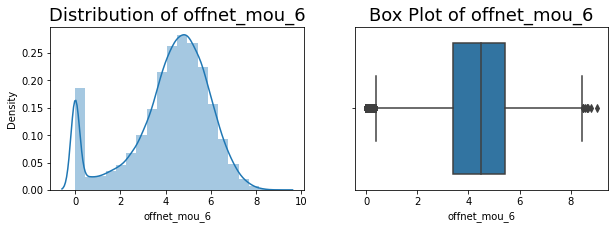

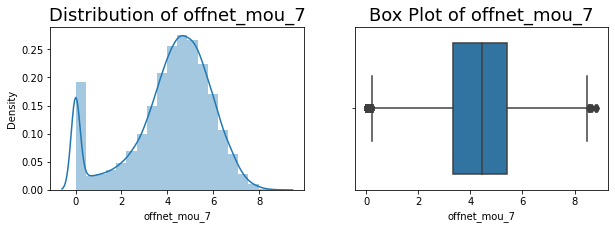

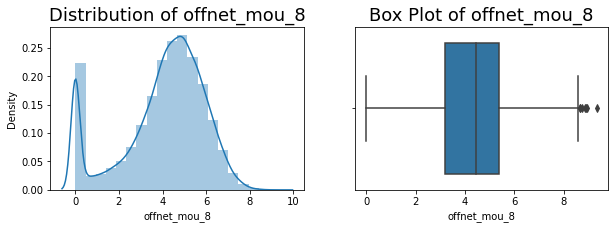

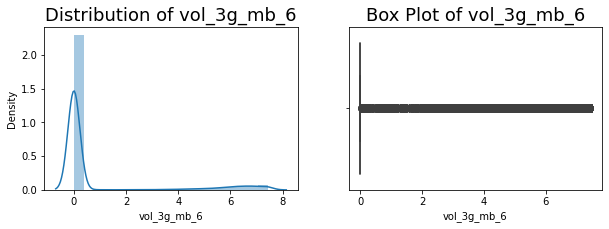

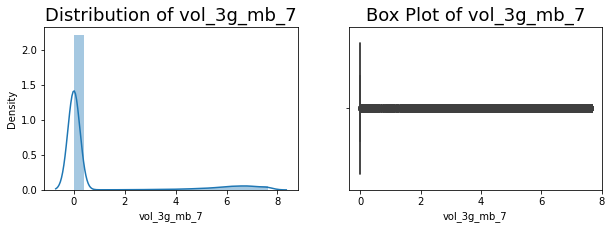

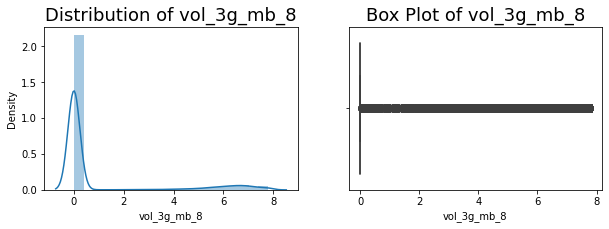

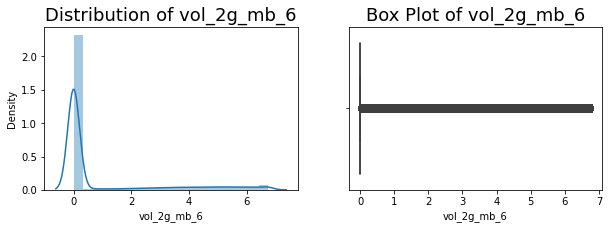

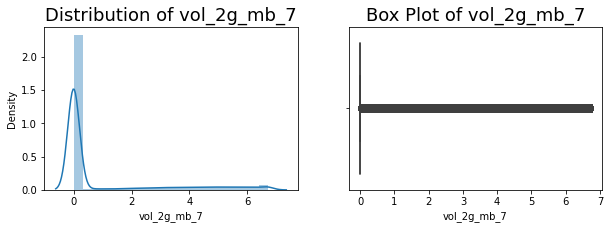

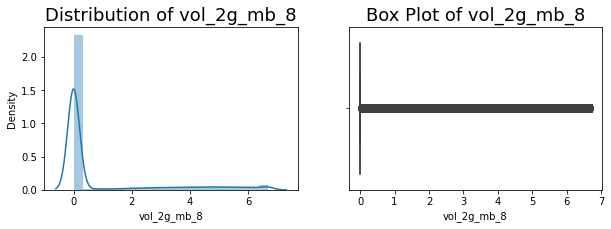

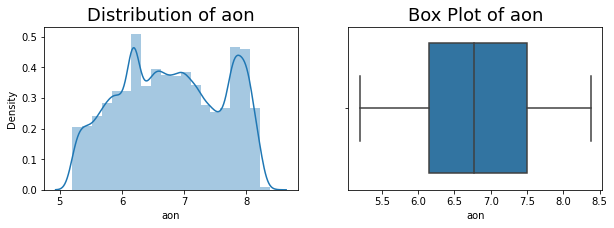

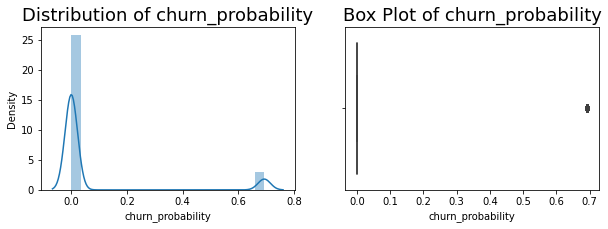

In [38]:
#numeric columns
numeric_columns = data.select_dtypes(include=["int64","float64"]).columns
for col in numeric_columns:
    # Create a new figure for each numeric column
    plt.figure(figsize=(10, 3))
       
    # Subplot 1: Distribution Plot
    plt.subplot(1, 2, 1)
    plt.title(f'Distribution of {col}', fontdict={'fontsize': 18})
    sns.distplot(data[col], bins=20)

    
    # Subplot 3: Box Plot
    plt.subplot(1, 2, 2)
    plt.title(f'Box Plot of {col}', fontdict={'fontsize': 18})
    sns.boxplot(x=col, data=data)
    
    # Display the figure for the current numeric column
    plt.show()

# Scaling the data

In [39]:
X = data.drop('churn_probability', axis=1)
y = data['churn_probability']


In [40]:
X.shape, y.shape

((69999, 16), (69999,))

In [41]:
X.columns

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')

In [42]:
#Splitting train and test data to avoid any contamination of the test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 16), (14000, 16), (55999,), (14000,))

In [45]:
X_train.head()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
id,,,,,,,,,,,,,,,,
30239,5.252273,5.662960,5.442418,4.963963,5.061202,5.032136,4.789656,4.970577,4.964871,0.000000,0.0,0.0,0.00000,3.949319,0.0,8.098035
36544,4.787492,4.262680,0.000000,5.236921,4.548494,0.000000,3.338967,2.259678,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,5.587249
42246,4.875197,4.394449,2.397895,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,7.771910
35873,5.332719,5.141664,4.941642,5.393309,4.921513,5.122415,5.207900,4.667487,4.799338,0.000000,0.0,0.0,0.00000,0.000000,0.0,6.198479
34575,5.164786,0.000000,0.000000,0.000000,0.000000,0.000000,0.506818,0.000000,0.000000,4.499476,0.0,0.0,5.05701,0.000000,0.0,6.630683


In [46]:
X_test.head()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
id,,,,,,,,,,,,,,,,
11746,4.948760,0.000000,3.737670,3.467609,4.139637,3.898127,3.361417,3.810655,3.556490,0.0,0.0,6.491467,0.000000,0.000000,4.214052,7.987524
62857,5.062595,4.615121,5.323010,0.000000,0.139762,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,6.471883,5.870483,6.689712,5.886104
21338,0.000000,0.000000,5.707110,3.886910,4.105285,4.413162,3.733136,3.703275,4.698296,0.0,0.0,0.000000,0.000000,0.000000,0.000000,6.300786
2500,5.860786,5.198497,5.831882,3.332562,4.088326,6.059193,2.824944,3.962906,5.971848,0.0,0.0,0.000000,0.000000,0.000000,0.000000,6.159095
67020,5.283204,4.110874,5.231109,5.146506,4.076011,5.185373,4.930365,3.971423,4.809253,0.0,0.0,0.000000,0.000000,0.000000,0.000000,5.521461


In [47]:
unseen.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69999,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,30,30,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1692,0.00,0.00,0.00
70000,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5,4,5,500,500,500,250,250,250,250,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,2533,0.00,0.00,0.00
70001,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,22.81,103.38,26.08,24.53,53.68,54.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,6,9,5,500,1000,1000,300,500,500,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,277,525.61,758.41,241.84
70002,43.550,171.390,24.400,5.31,2.16,0.00,40.04,205.01,24.01,0.00,0.00,0.00,0.00,0.00,0.00,5.31,0.00,0.00,2.94,98.61,20.51,0.00,0.00,2.35,0.0,6.18,0.00,8.26,98.61,22.86,0.00,2.16,0.00,37.09,94.36,0.00,0.0,0.0,0.0,37.09,96.53,0.00,0.0,0.0,0.0,0.00,12.03,1.15,0.0,0.0,0.0,45.36,207.18,24.01,58.11,54.64,23.04,487.94,449.83

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
new_vars=X_train.columns
unseen=unseen[new_vars]
#unseen['churn_probability'] = 0
unseen_scaled = scaler.transform(unseen)

# Using PCA to reduce dimensions

The goal of PCA is to transform the original features into a new set of uncorrelated features (principal components) that retain most of the information in the data. Typically, you may choose to retain a subset of the principal components that capture a high percentage of the total variance, effectively reducing the dimensionality of the dataset.
The percentage of variance captured serves as a quantitative measure of how well the reduced set of principal components represents the original data.

In [49]:
from sklearn.decomposition import PCA
pca = PCA(random_state=42) 
pca_components = pca.fit(X_train_scaled)
#PC1 is the linear combination of the original features that captures the most variance in the data.Each subsequent principal component captures less variance than the previous ones.
#If you perform PCA on a dataset with n original features, you will obtain n principal components.

In [50]:
#First, you came to know how much variance is being explained by each Principal Component using the following code:
pca.explained_variance_ratio_

array([0.31031043, 0.23661654, 0.10956001, 0.07084805, 0.06158325,
       0.05398212, 0.03140788, 0.02933849, 0.02280893, 0.01536957,
       0.01498328, 0.01462888, 0.01307774, 0.00924929, 0.00378634,
       0.0024492 ])

In [51]:

# Cumulative explained variance
#cumulative variance explained by the top 2 principal components is the sum of their individual variances, given by 72.8 +23 =95.8 %. Similarly, you can continue this for 3 and 4 components.
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)


##### Scree Plot

If you plot the number of components on the X-axis and the total variance explained on the Y-axis, the resultant plot is also known as a Scree-Plot. 
#X-axis (Number of Components):This is usually a range from 1 to the total number of features in your dataset.
#Y-axis (Cumulative Explained Variance):It shows the percentage of total variance in the dataset that is explained by the corresponding number of principal components on the X-axis.

Look for the "elbow" or a point where the rate of increase in the explained variance slows down. The elbow is often considered the optimal number of components to retain, as it signifies a balance between retaining enough information and avoiding overfitting.

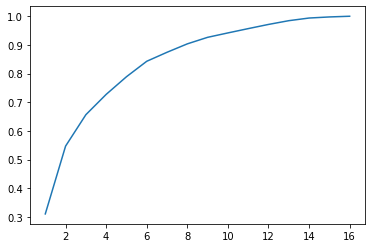

In [52]:
#scree plot
plt.plot(range(1,len(cumulative_variance)+1), cumulative_variance)

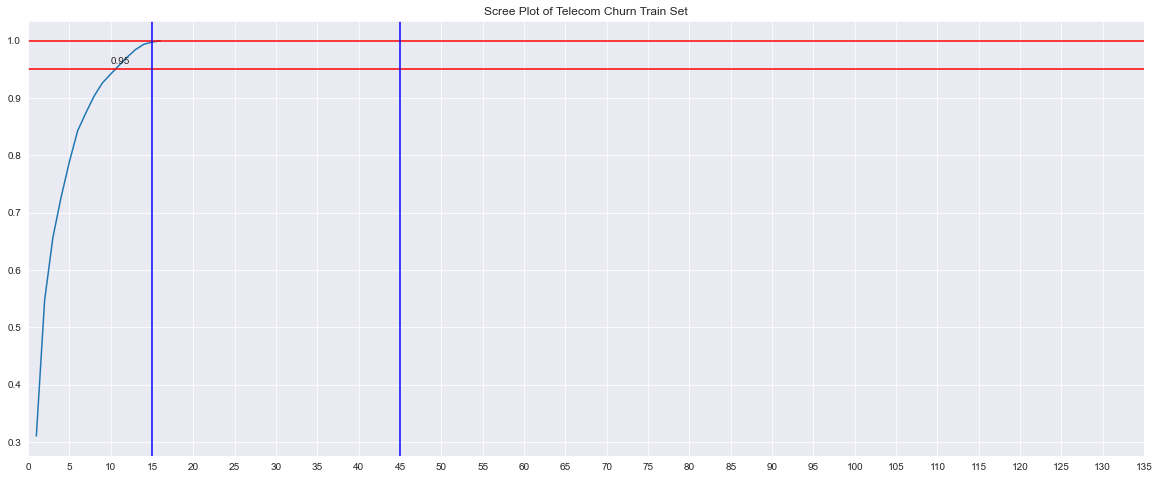

In [53]:
var_cum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(20,8))
sns.set_style('darkgrid')
sns.lineplot(x=np.arange(1, len(var_cum) + 1), y=var_cum)
plt.xticks(np.arange(0,140,5))
plt.axhline(0.95,color='r')
plt.axhline(1.0,color='r')
plt.axvline(15,color='b')
plt.axvline(45,color='b')
plt.text(10,0.96,'0.95')

plt.title('Scree Plot of Telecom Churn Train Set');

From the above scree plot, it is clear that 95% of variance in the train set can be explained by first 10 principal component and 100% of variance is explained by the first 15 principal components.

Choosing the required number of components:
- From the scree plot that you saw previously, you decided to keep ~95% of the information in the data that we have and for that, you need only 10 components. Hence you instantiate a new PCA function with the number of components as 10. This function will perform the dimensionality reduction on our dataset and reduce the number of columns from 16 to 10.

In [54]:
# Perform PCA using the first 10 components
pca = PCA(n_components=10, random_state=42)
transformed_data = pca.fit_transform(X_train_scaled)
#The transformed data is stored in a new DataFrame (X_train_pca), where each column represents one of the 15 principal components. The column names are labeled as "PC_1" through "PC_15."
X_train_pca = pd.DataFrame(transformed_data, columns=["PC_"+str(x) for x in range(1,11)], index = X_train.index)
data_train_pca = pd.concat([X_train_pca, y_train], axis=1)
data_train_pca.head()


,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,churn_probability
id,,,,,,,,,,,
30239,-1.120469,-0.245301,0.149894,0.537748,-1.437109,-0.804612,0.105420,-0.205317,1.213146,0.367807,0
36544,2.775793,-1.173879,-2.336826,0.215264,1.626201,-0.879555,-0.470991,-0.137745,-0.232700,-0.571212,1
42246,5.017181,-0.736903,-0.054111,-0.327535,-1.045789,-0.986268,0.836874,-2.092629,-0.033000,0.417265,1
35873,-0.841219,-1.067055,-0.212276,0.046153,0.700782,0.443625,-0.035217,0.024239,0.125197,0.048825,0
34575,6.040898,0.709529,-1.266910,-0.100270,-0.428155,0.402050,2.410889,0.741018,-1.354408,0.499367,0


<Axes: >

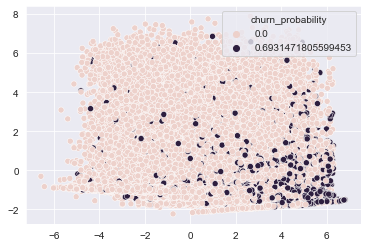

In [58]:
sns.scatterplot(x=transformed_data[:,0], y=transformed_data[:,1], hue=y_train)

<Axes: >

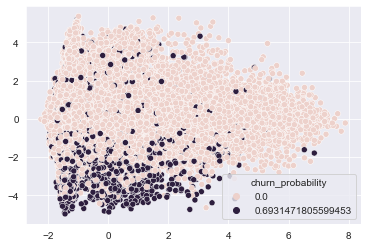

In [59]:
sns.scatterplot(x=transformed_data[:,1], y=transformed_data[:,2], hue=y_train)

If there is overlap among the classes in the plot, it suggests that the selected principal components may not sufficiently separate the classes. Overlapping classes can make it challenging for a machine learning model to accurately classify instances.


In [55]:
X_test_pca = pd.DataFrame(pca.transform(X_test_scaled),columns=["PC_"+str(x) for x in range(1,11)], index = X_test.index)
unseen_pca = pd.DataFrame(pca.transform(unseen_scaled),columns=["PC_"+str(x) for x in range(1,11)], index = unseen.index)

# 3. Model building & Evaluation

#### Model 1: Random Forest Classifier Model 

In [56]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
def display_scores(y_true, y_pred, y_pred_proba, plot=False):
    cfm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cfm.ravel()
    print(f"Accuracy Score: {round(accuracy_score(y_true, y_pred)*100,4)}%")
    print(f"Sensitivity/Recall/TPR: {round(tp/(tp+fn)*100,4)}%")
    print(f"FPR: {round(fp/(tn+fp)*100,4)}%")
    print(f"Specificity: {round(tn/(tn+fp)*100,4)}%")
    print(f"Precision: {round(tp/(tp+fp)*100,4)}%")
    print(f"F1 Score: {round(f1_score(y_true, y_pred)*100,4)}%")
    print(f"Prediction AUC Score: {round(roc_auc_score(y_true, y_pred)*100,4)}%")
    print(f"Mean Square Error: {round(mean_squared_error(y_true, y_pred),10)}")
    print("Confusion Matrix:")
    print(cfm)
    if plot:
        plotAUC(y_true, y_pred_proba)
        
# function for prediction metrics
def displayPredictionMetrics(model, X_train, y_train, showROC=False):
    y_pred_proba = model.predict_proba(X_train)
    y_pred = model.predict(X_train)
    display_scores(y_train, y_pred, y_pred_proba, showROC)
    
def plotAUC(y_true, y_pred_proba):
    fpr, tpr, threshold = roc_curve(y_true, y_pred_proba[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

###### Initial Model Building: Applying logistic regression on the data on our Principal components

Let's build a quick model with logistic regression and the first 10 PCA components.

In [126]:
X_train_pca.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
id,,,,,,,,,,
43835,1.081958,-1.308493,1.043201,-0.395740,-1.119351,-0.696997,-0.235111,0.654589,0.401018,1.075428
27174,-1.826774,2.276451,-0.315306,3.311707,-0.514158,0.019031,-0.063680,0.226703,-0.062786,-0.007798
3495,-3.466763,1.285014,-0.276338,2.256054,0.300697,-1.135232,-0.519963,1.038464,1.633614,-0.273008
69589,-0.151557,2.235246,-0.296063,3.370639,0.214706,-0.205797,-0.141935,0.164242,0.121724,0.079581
69801,0.756487,-1.179886,-1.571276,0.211123,1.513867,2.348813,0.140312,-0.196229,0.722777,-0.715850


In [127]:
y_train.head()

id
43835    0
27174    0
3495     0
69589    0
69801    0
Name: churn_probability, dtype: int64

In [128]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
#lr_model_pca=lr.fit(transformed_data[:,:10], y_train)
lr_model_pca = lr.fit(X_train_pca.iloc[:, :10], y_train)

In [129]:
# find train prediction metrics
displayPredictionMetrics(lr_model_pca, X_train_pca, y_train)

Accuracy Score: 92.1088%
Sensitivity/Recall/TPR: 45.5703%
FPR: 2.5823%
Specificity: 97.4177%
Precision: 66.8116%
F1 Score: 54.1835%
Prediction AUC Score: 71.494%
Mean Square Error: 0.0789121234
Confusion Matrix:
[[48967  1298]
 [ 3121  2613]]


We can see a high amount of type 2 error( false negative).A low sensitivity suggests that the model is not effectively capturing a significant portion of positive cases. This could be indicative of class imbalance, where the model may not be performing well on the minority class.
Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0.

Accuracy Score: 92.55%
Sensitivity/Recall/TPR: 45.3505%
FPR: 2.2139%
Specificity: 97.7861%
Precision: 69.4414%
F1 Score: 54.868%
Prediction AUC Score: 71.5683%
Mean Square Error: 0.0745
Confusion Matrix:
[[12323   279]
 [  764   634]]


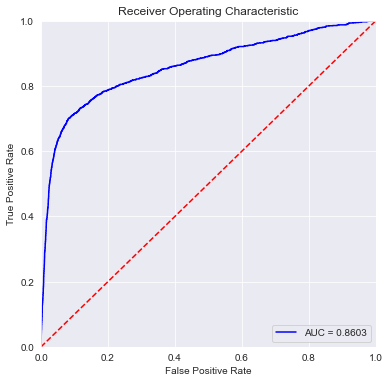

In [130]:
# find train prediction metrics
displayPredictionMetrics(lr_model_pca, X_test_pca, y_test,True)
#Visualize the Receiver Operating Characteristic (ROC) curve and check the Area Under the Curve (AUC). AUC can provide insights into the model's ability to discriminate between classes.
#A curve that hugs the top-left corner suggests good model performance.
#Area under curve is small. This doesnot indicate good model performance

We can see from the model performance that the Sesitivity has been decreased while evaluating the model.

We are more focused on higher Sensitivity/Recall score than the accuracy.
Beacuse we need to care more about churn cases than the not churn cases. The main goal is to reatin the customers, who have the possiblity to churn. There should not be a problem, if we consider few not churn customers as churn customers and provide them some incentives for retaining them. Hence, the sensitivity score is more important here.

In [131]:
#Calculate the class distribution using metrics like the percentage of samples in each class.
churn_percentage = data['churn_probability'].value_counts(normalize=True) * 100
print("Churn Percentage:\n", churn_percentage)
imbalance_ratio = data['churn_probability'].value_counts()[0] / data['churn_probability'].value_counts()[1]
print("Imbalance Ratio:", imbalance_ratio)

Churn Percentage:
 churn_probability
0    89.811283
1    10.188717
Name: proportion, dtype: float64
Imbalance Ratio: 8.814778463264162


###### Combine PCA and Random Forest

- Objective: By combining PCA and Random Forest, you can leverage the dimensionality reduction benefits of PCA while utilizing the ability of Random Forest to capture complex relationships and identify important features.
- Application: After reducing the dimensionality with PCA, feed the transformed data into a Random Forest model. Analyze the feature importance scores to understand which principal components or original features contribute significantly to the model's predictions.

In [132]:
#class imbalance handling
#Using class_weight='balanced' in Learning Algorithms to handle class imbalance problem.
rfc = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced',n_jobs=-1)
rfc.fit(X_train_pca,y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [133]:
# find train prediction metrics
displayPredictionMetrics(rfc, X_train_pca, y_train)

Accuracy Score: 99.9964%
Sensitivity/Recall/TPR: 99.9651%
FPR: 0.0%
Specificity: 100.0%
Precision: 100.0%
F1 Score: 99.9826%
Prediction AUC Score: 99.9826%
Mean Square Error: 3.57149e-05
Confusion Matrix:
[[50265     0]
 [    2  5732]]


Accuracy Score: 92.8429%
Sensitivity/Recall/TPR: 44.6352%
FPR: 1.8092%
Specificity: 98.1908%
Precision: 73.2394%
F1 Score: 55.4667%
Prediction AUC Score: 71.413%
Mean Square Error: 0.0715714286
Confusion Matrix:
[[12374   228]
 [  774   624]]


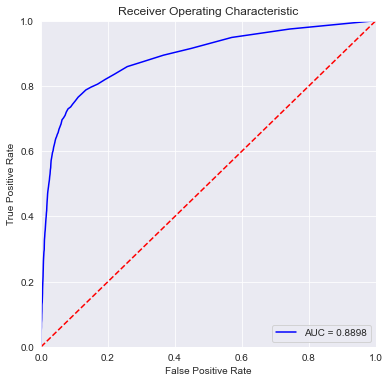

In [134]:
# find test prediction metrics
displayPredictionMetrics(rfc, X_test_pca, y_test, True)

The model has a high accuracy, but the sensitivity (recall) is low, suggesting that there may be room for improvement in capturing more positive instances.
The model appears to perform well in terms of specificity and precision.
The F1 score indicates a balance between precision and recall, but there is room for improvement.
The AUC score suggests a moderate ability to distinguish between classes.

###### HyperParameter Tuning

In [136]:
# Hyper parameter Tuning using GridSearchCV.The best parameters are determined based on cross-validated performance
#Using scoring='average_precision' is a suitable metric for hyperparameter tuning in the presence of class imbalance, especially when you are more concerned with correctly identifying positive cases (churn) and less concerned about misclassifying negative cases (non-churn).
#If missing positive cases (false negatives) are more critical, you might prioritize 'recall.' If you are concerned about precision and recall trade-offs and the class distribution is imbalanced, 'average_precision' can be a good choice.


rf = RandomForestClassifier()

params = {
    'n_estimators'  : [100],
    'max_depth' : [9,10,11],
    'min_samples_leaf' : [5,10,15,20]
}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
pca_rf_model_search = GridSearchCV(estimator=rf, param_grid=params, 
                                   cv=folds, scoring='average_precision', verbose=True, n_jobs=-1)

pca_rf_model_search.fit(X_train_pca, y_train) #This fits the GridSearchCV instance, which internally performs cross-validated training using different hyperparameter combinations.

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [9, 10, 11],
                         'min_samples_leaf': [5, 10, 15, 20],
                         'n_estimators': [100]},
             scoring='average_precision', verbose=True)

In [137]:
# Optimum Hyperparameters
print('We can get accuracy of',pca_rf_model_search.best_score_,'with Best identified Parameters',pca_rf_model_search.best_params_)

We can get accuracy of 0.6256339412114379 with Best identified Parameters {'max_depth': 11, 'min_samples_leaf': 5, 'n_estimators': 100}


In [138]:
# Modelling using the best PCA-RandomForest Estimator 
#This fits a new RandomForestClassifier using the best hyperparameters obtained from the grid search
pca_rf_best = RandomForestClassifier(**pca_rf_model_search.best_params_,
                                     class_weight='balanced',
                                     random_state=RANDOM_STATE)
pca_rf_best_fit = pca_rf_best.fit(X_train_pca, y_train)


###### Evaluating The PCA Random Forest Model

In [139]:
# find train prediction metrics
displayPredictionMetrics(pca_rf_best_fit, X_train_pca, y_train)


Accuracy Score: 92.1749%
Sensitivity/Recall/TPR: 81.4789%
FPR: 6.605%
Specificity: 93.395%
Precision: 58.4585%
F1 Score: 68.0752%
Prediction AUC Score: 87.437%
Mean Square Error: 0.0782513973
Confusion Matrix:
[[46945  3320]
 [ 1062  4672]]


Accuracy Score: 91.3%
Sensitivity/Recall/TPR: 71.1016%
FPR: 6.4593%
Specificity: 93.5407%
Precision: 54.9779%
F1 Score: 62.0087%
Prediction AUC Score: 82.3211%
Mean Square Error: 0.087
Confusion Matrix:
[[11788   814]
 [  404   994]]


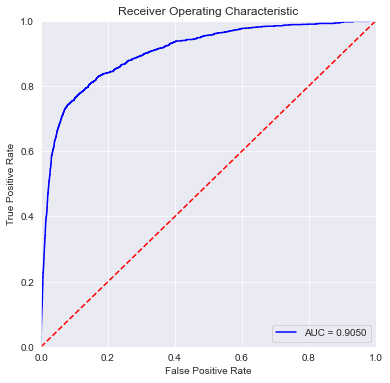

In [140]:
# find test prediction metrics
displayPredictionMetrics(pca_rf_best_fit, X_test_pca, y_test, True)

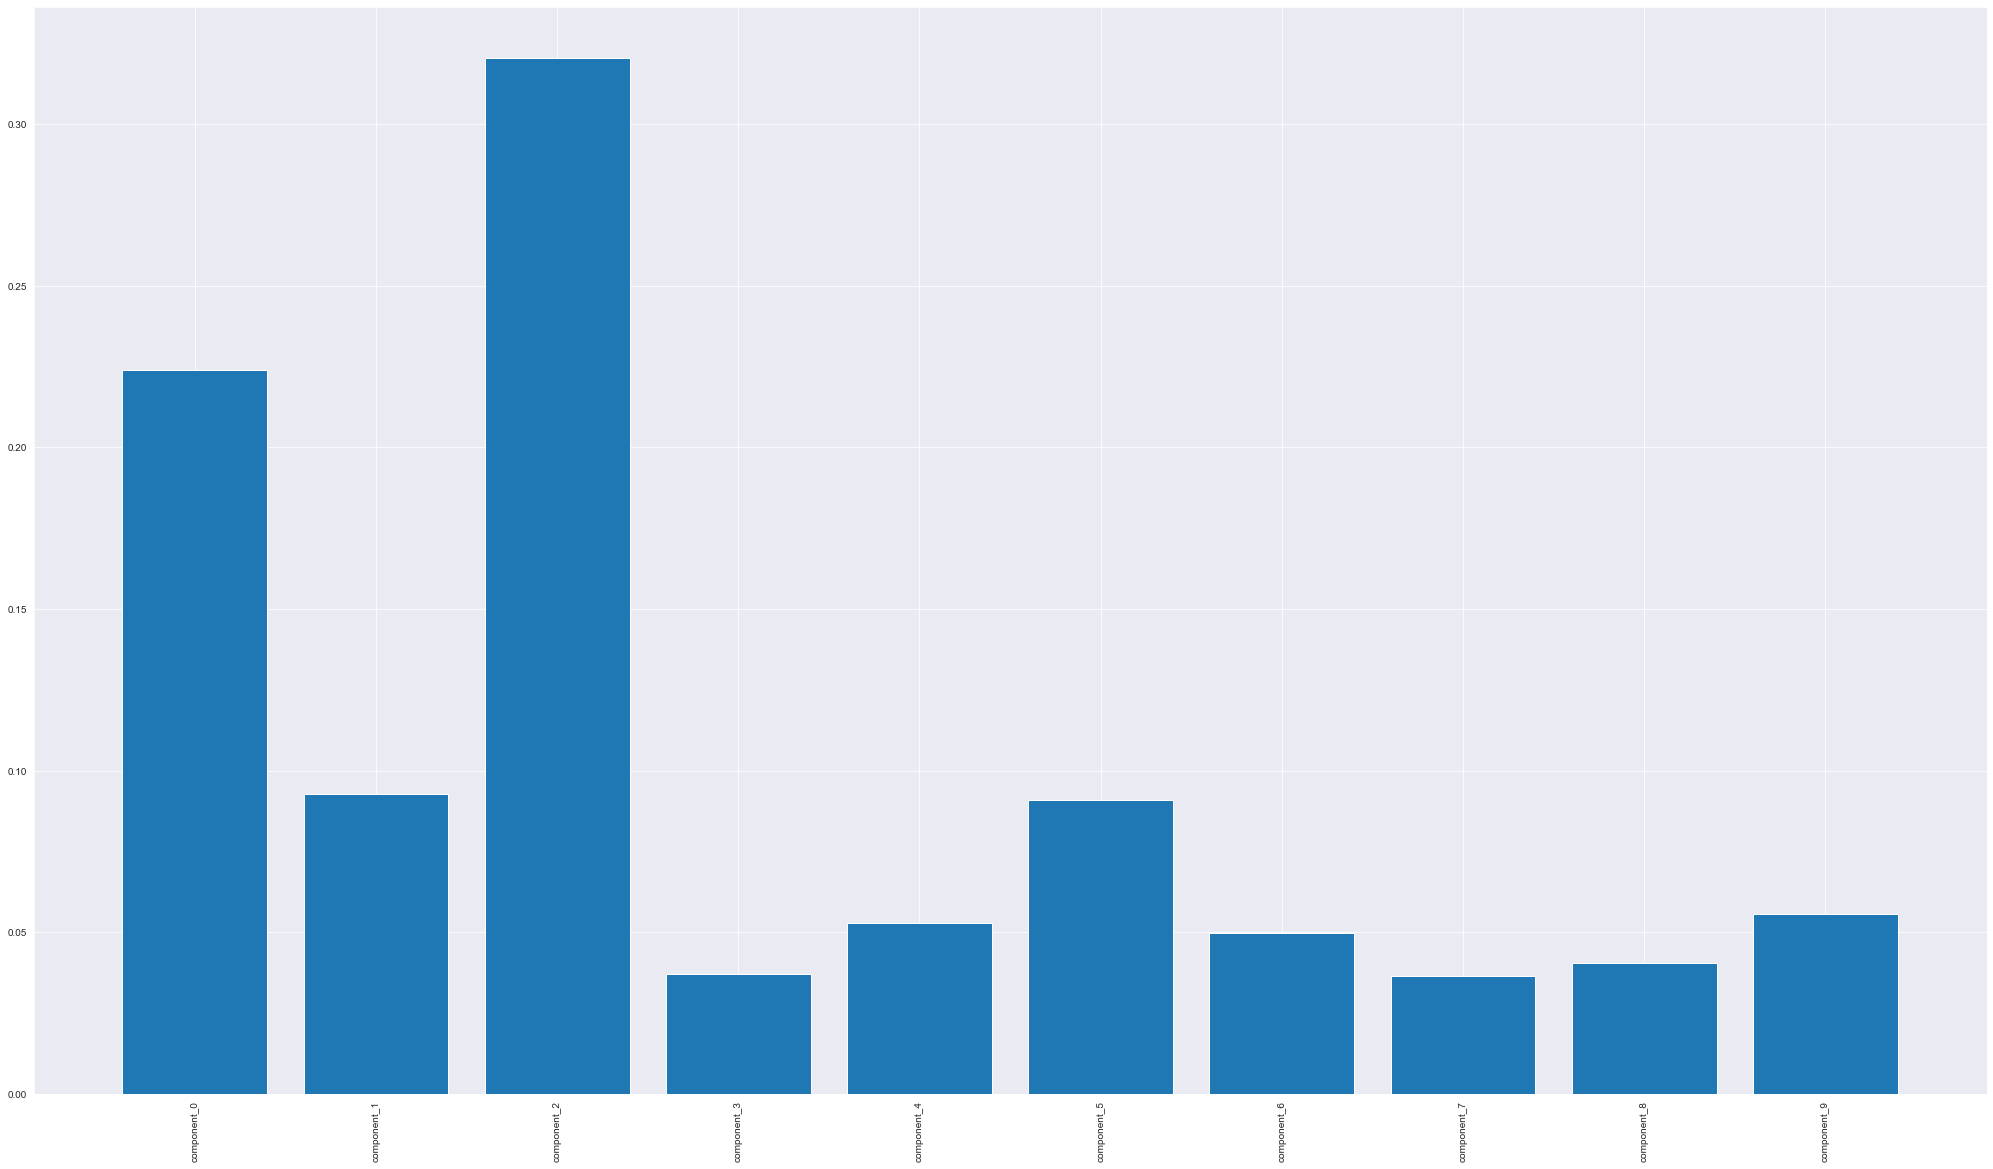

In [143]:
# Create feature importances DataFrame
#Let's also check which of the components have high feature importances towards the end goal of churn prediction.
feature_importances = pd.DataFrame({'col': ['component_' + str(i) for i in range(X_train_pca.shape[1])], 
                                    'importance':pca_rf_best_fit.feature_importances_})


# Plot the feature importances
plt.figure(figsize=(35,20))
plt.xticks(rotation=90)
plt.bar(feature_importances['col'], feature_importances['importance'])
plt.show()

### Model 2: Gradient Boosting Model

###### Initial Model Building

In [94]:
import xgboost as xgb
#scale_pos_weight: This parameter is used to handle imbalanced classes. It is set to the ratio of the number of negative class samples to the number of positive class samples. It assigns higher weights to the minority class, helping the model to give more importance to the positive class.
xgbc =xgb.XGBClassifier(
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    n_jobs=-1
)
xgbc.fit(transformed_data,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [100]:
# find train prediction metrics
displayPredictionMetrics(xgbc, X_train_pca, y_train)

Accuracy Score: 92.6142%
Sensitivity/Recall/TPR: 92.4008%
FPR: 7.3617%
Specificity: 92.6383%
Precision: 58.7087%
F1 Score: 71.7987%
Prediction AUC Score: 92.5196%
Mean Square Error: 0.0738584618
Confusion Matrix:
[[46598  3703]
 [  433  5265]]


Accuracy Score: 89.0929%
Sensitivity/Recall/TPR: 71.4086%
FPR: 8.8891%
Specificity: 91.1109%
Precision: 47.8281%
F1 Score: 57.2867%
Prediction AUC Score: 81.2598%
Mean Square Error: 0.1090714286
Confusion Matrix:
[[11449  1117]
 [  410  1024]]


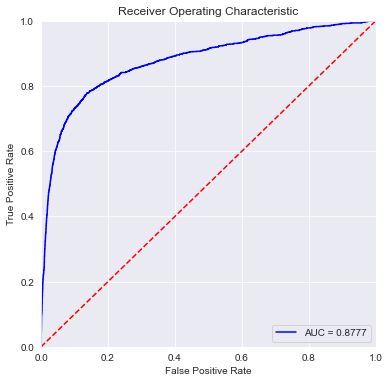

In [97]:
# find test prediction metrics
displayPredictionMetrics(xgbc, X_test_pca, y_test, True)

###### HyperParameter Tuning

Hyperparameter tuning for an XGBoost classifier using cross-validated grid search.

In [60]:
def plot_xgb_hyperparameters(scores, param):
    lr = scores[scores['param_subsample']==param]
    plt.plot(lr["param_learning_rate"], lr["mean_test_score"])
    plt.plot(lr["param_learning_rate"], lr["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('Accuracy')
    plt.title("Subsample="+str(param))
    plt.ylim([0.4, 1])
    plt.legend(['test_score', 'training_score'])
    plt.xscale('log')

In [101]:
# tuning all final hyperparameters for xgb
import sklearn.model_selection as skms
learning_rate = [0.1,0.2,0.3]
subsample = [0.3,0.4,0.5]
parameters = {'learning_rate': learning_rate, 'subsample': subsample}
#scale_pos_weight is used for imbalance class handling
xgb_hyper = xgb.XGBClassifier(scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1]))

# cross validation
model_cv_xgb_hyper = skms.GridSearchCV(estimator = xgb_hyper, n_jobs=-1, param_grid = parameters, 
                             scoring= 'average_precision', cv = 3, return_train_score=True, verbose = 3)
model_cv_xgb_hyper.fit(transformed_data, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'subsample': [0.3, 0.4, 0.5]},
             return_train_score=True, scoring='average_precision', verbose=3)

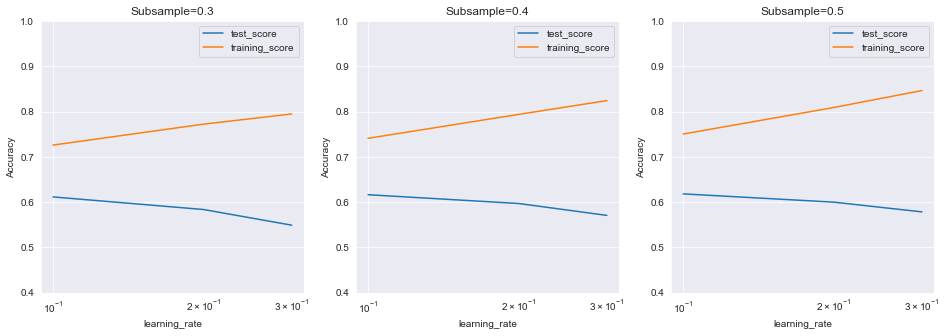

In [104]:
# display cv scores and plot gamma vs C
xgb_scores = pd.DataFrame(model_cv_xgb_hyper.cv_results_)
xgb_scores['param_learning_rate'] = xgb_scores['param_learning_rate']

plt.figure(figsize=(16,5))

for x, s in enumerate(subsample):
    plt.subplot(1, 3, x+1)
    plot_xgb_hyperparameters(xgb_scores, s)
plt.show()

In [105]:
model_cv_xgb_hyper.best_params_

{'learning_rate': 0.1, 'subsample': 0.5}

###### Evaluating Model

In [106]:
# find train prediction metrics
print("Evaluating XGB Model with best parameters on Train Dataset",model_cv_xgb_hyper.best_params_,"\n")
displayPredictionMetrics(model_cv_xgb_hyper, X_train_pca, y_train)

Evaluating XGB Model with best parameters on Train Dataset {'learning_rate': 0.1, 'subsample': 0.5} 

Accuracy Score: 89.3445%
Sensitivity/Recall/TPR: 83.8013%
FPR: 10.0276%
Specificity: 89.9724%
Precision: 48.6302%
F1 Score: 61.5454%
Prediction AUC Score: 86.8869%
Mean Square Error: 0.1065554742
Confusion Matrix:
[[45257  5044]
 [  923  4775]]


Evaluating XGB Model with best parameters on Test Dataset {'learning_rate': 0.1, 'subsample': 0.5} 

Accuracy Score: 88.1929%
Sensitivity/Recall/TPR: 74.8257%
FPR: 10.2817%
Specificity: 89.7183%
Precision: 45.37%
F1 Score: 56.4885%
Prediction AUC Score: 82.272%
Mean Square Error: 0.1180714286
Confusion Matrix:
[[11274  1292]
 [  361  1073]]


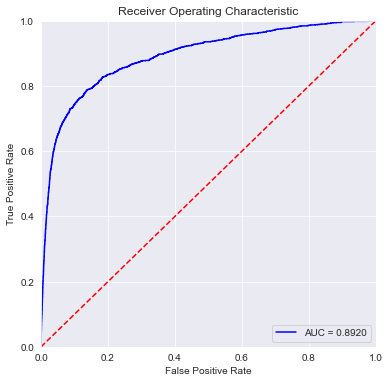

In [107]:
# find test prediction metrics
print("Evaluating XGB Model with best parameters on Test Dataset",model_cv_xgb_hyper.best_params_,"\n")
displayPredictionMetrics(model_cv_xgb_hyper, X_test_pca, y_test, True)

##### Feature Importance Xgboost Model:important variables that are strong predictors of churn

In [110]:
# Assuming model_cv_xgb_hyper is your GridSearchCV object

# Get the best XGBoost model from the grid search
best_xgb_model = model_cv_xgb_hyper.best_estimator_

# Access feature importances from the best model
feature_importances = best_xgb_model.feature_importances_

# Now you can use feature_importances to create your scatter plot
import plotly.graph_objects as go
import plotly.offline as py


trace = go.Scatter(
    y=feature_importances,
    x=X_train.columns.values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1.3,
        size=12,
        color=feature_importances,
        colorscale='Portland',
        showscale=True
    ),
    text=X_train.columns.values
)

data = [trace]

layout = go.Layout(
    autosize=True,
    title='XGBOOST Model Feature Importance',
    hovermode='closest',
    xaxis=dict(
        ticklen=5,
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title='Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter')

### Model 3:Support Vector Machine Model

###### Initial Model Building

In [144]:
#Label Transformation for SVM:
#SVMs conventionally use labels +1 and -1, where +1 represents the positive class and -1 represents the negative class.
y_train_svc = y_train.map({1:1, 0:-1})
y_test_svc = y_test.map({1:1, 0:-1})

In [ ]:
# fit model
from sklearn import svm
svc = svm.SVC(class_weight='balanced', probability=True, kernel='rbf')
svc.fit(X_train_pca,y_train_svc)

In [ ]:
# find train prediction metrics
displayPredictionMetrics(svc, X_train_pca, y_train_svc)

In [ ]:
# find test prediction metrics
displayPredictionMetrics(svc, X_test_pca, y_test_svc, True)

###### HyperParameter Tuning

In [ ]:
def plot_svc_hyperparameters(scores, param):
    gamma = scores[scores['param_gamma']==param]
    plt.plot(gamma["param_C"], gamma["mean_test_score"])
    plt.plot(gamma["param_C"], gamma["mean_train_score"])
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.title("Gamma="+str(param))
    plt.ylim([0, 1])
    plt.legend(['test_score', 'training_score'])
    plt.xscale('log')

In [ ]:
# tuning all final hyperparameters for svc
gamma = [1e-1,1e-2, 1e-3, 1e-4]
C = [1, 10, 100, 1000]
parameters = {'gamma': gamma, 'C': C}
svc_hyper = svm.SVC(class_weight='balanced', probability=True, kernel='rbf')

# cross validation
model_cv_svc_hyper = skms.GridSearchCV(estimator = svc_hyper, n_jobs=-1, param_grid = parameters, 
                             scoring= 'recall', cv = 3, return_train_score=True, verbose = 3)            
model_cv_svc_hyper.fit(X_train_pca, y_train_svc)

In [ ]:
# display cv scores and plot gamma vs C
svc_scores = pd.DataFrame(model_cv_svc_hyper.cv_results_)
svc_scores['param_C'] = svc_scores['param_C']

plt.figure(figsize=(16,5))

for x, g in enumerate(gamma):
    plt.subplot(1, 4, x+1)
    plot_svc_hyperparameters(svc_scores, g)
plt.show()

###### Evaluating Model

In [ ]:
print("Evaluating SVC Model with best parameters on Train Dataset",model_cv_svc_hyper.best_params_,"\n")
displayPredictionMetrics(model_cv_svc_hyper, X_train_pca, y_train_svc)

In [ ]:
print("Evaluating SVC Model with best parameters on Test Dataset",model_cv_svc_hyper.best_params_,"\n")
displayPredictionMetrics(model_cv_svc_hyper, X_test_pca, y_test_svc, True)

## 4. High Performance Model Observations

- The sensitivity score of RandomForestClassifier model for Train is 81.4% and Test is 71.1%
- The sensitivity score of XGBClassifier model for Train is 83.8% and Test is 74.8%


The XGBClassifier model is performing good with around 74.8% of test accuracy. It can be used in production environment.

#### Recommend strategies to manage customer churn based on your observations.

- <strong>Low Local Incoming and Outgoing ISD Calls in August</strong>:
Target customers exhibiting lower usage of incoming local calls and outgoing ISD calls during the action phase, particularly in the month of August.
- <strong>Decreased Outgoing Others Charge in July and Incoming Others in August</strong>: 
Focus on customers with reduced charges for outgoing calls to other operators in July and decreased charges for incoming calls from other operators in August.
- <strong>Higher Monthly 3G Recharge in August</strong>:
Identify customers with an increase in 3G recharge during August, as they are more prone to churn. This segment may require special attention.
- <strong>Decline in STD Incoming Minutes for Operator T to Fixed Lines of T in August</strong>:
    Customers showing a reduction in STD incoming minutes from operator T to fixed lines of T during August are at an increased risk of churning.
- <strong>Decrease in Monthly 2G Usage for August</strong>:
Pay attention to customers who exhibit a decline in monthly 2G usage for the month of August, as this group is more likely to churn.

# 5. Creating submission file¶

In [118]:
new_vars=X_train.columns

In [119]:
X_train.columns

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')

In [120]:
X_train_pca.columns

Index(['PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9',
       'PC_10'],
      dtype='object')

In [121]:
submission_data = unseen_pca
submission_data.shape

(30000, 10)

In [122]:
unseen_pca.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
id,,,,,,,,,,
69999,-256.510320,-46.566440,-0.513731,-387.562317,-1850.689793,-678.644016,112.133289,-230.277833,-26.275088,-12.942870
70000,-1029.076797,-55.339324,-43.668328,-561.824792,-2710.245303,-1038.104861,163.248602,-360.565299,-77.622257,3.291452
70001,-382.784168,140.432785,112.383012,-23.327380,-207.543103,-124.002362,187.514778,-580.889889,22.183124,-35.839282
70002,-278.284383,-29.489522,-6.172000,-273.641253,-1307.113429,-615.017762,86.704415,-184.079476,-54.985854,16.360760
70003,-592.195496,26.708933,71.787396,-85.131760,-448.610755,-132.092103,100.805092,-225.062712,2.560338,-263.288433


In [123]:
unseen['churn_probability'] = model_cv_xgb_hyper.predict(submission_data)
output = unseen[['churn_probability']]
output.head()

,churn_probability
id,
69999,0
70000,0
70001,0
70002,0
70003,0


In [125]:
#predict whether a high-value customer will churn or not
output.to_csv('Treza_Priyanshu_submission.csv',index=True)